## 1. Precipitation

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from calendar import month_abbr
from functools import reduce
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import urllib.request

#### a. import and organize the data

In [54]:
# creating function that downlaod the data from the station website:

def download_data(station_name, station_code):
    url_daily = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    url_monthly = 'https://www.ncei.noaa.gov/data/gsom/access/'
#     download daily data - uncomment to make this work
    urllib.request.urlretrieve(url_daily + station_code + '.csv',
                               station_name + '_daily.csv')
# download monthly data
    urllib.request.urlretrieve(url_monthly + station_code + '.csv',
                               station_name + '_monthly.csv')

In [55]:
# appling the function on Merced station:
download_data('MERCED','USC00045532')

defining *df_month* for monthly data and before we start with analyzing, lets plot the rainfall data, to see how it looks like

In [56]:
df_month = pd.read_csv('MERCED_monthly.csv', sep=",")
df_month['DATE'] = pd.to_datetime(df_month['DATE'])
df_month = df_month.set_index('DATE')  # making the date the index
# df_month  # uncomment to see the full DataFrame

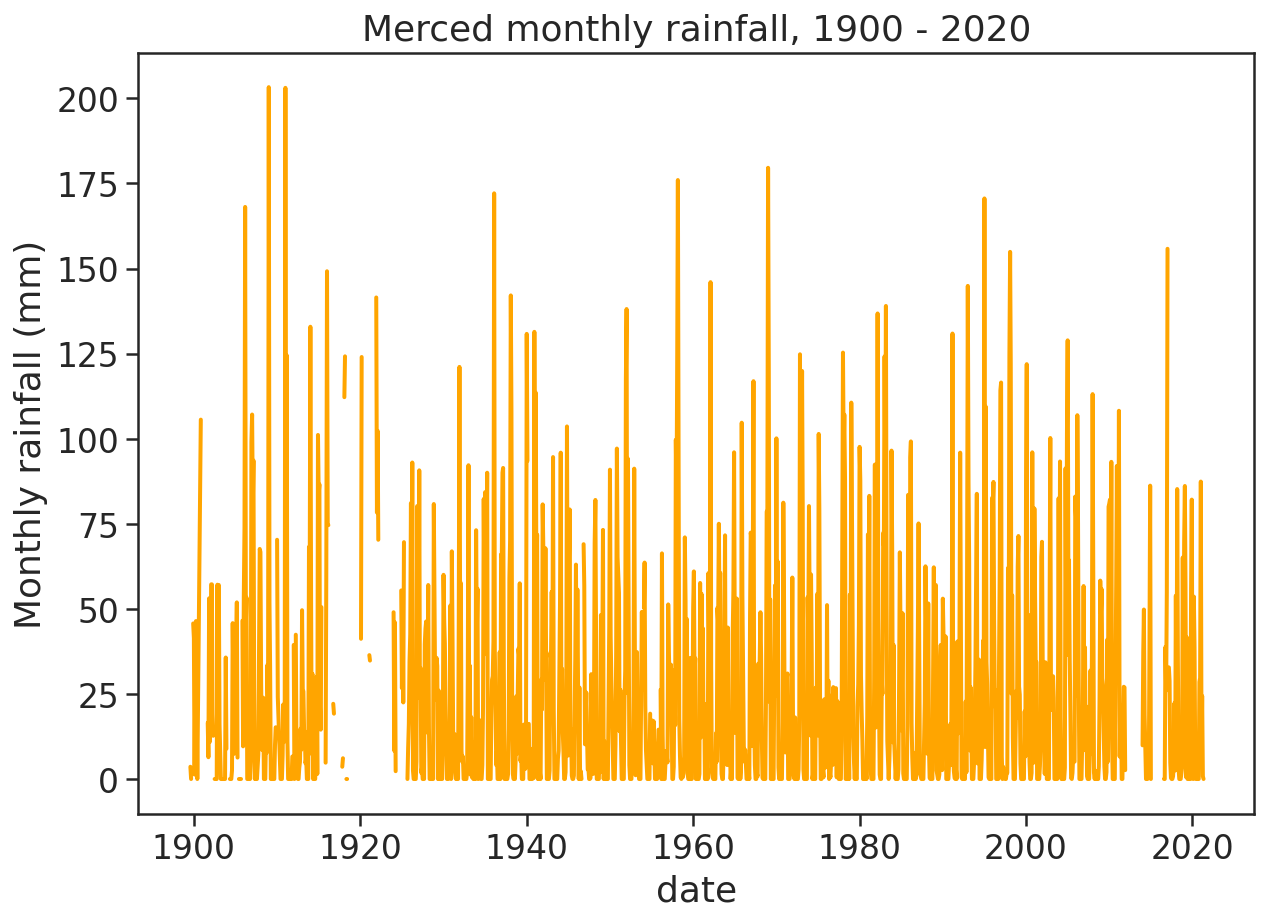

In [57]:
#graph:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(df_month['PRCP'], color="orange",  linewidth=2)
ax.set(xlabel="date",
       ylabel="Monthly rainfall (mm)",
       title="Merced monthly rainfall, 1900 - 2020");

As we can see the graphs look very good but we Should pay attention that it looks like there is no data from Merced between 1915-1924 and between 2011-2016.
so, lets limit the range of data between 1924 - 2011.
 we still have 87 years of data, its good enough for this analysis :)

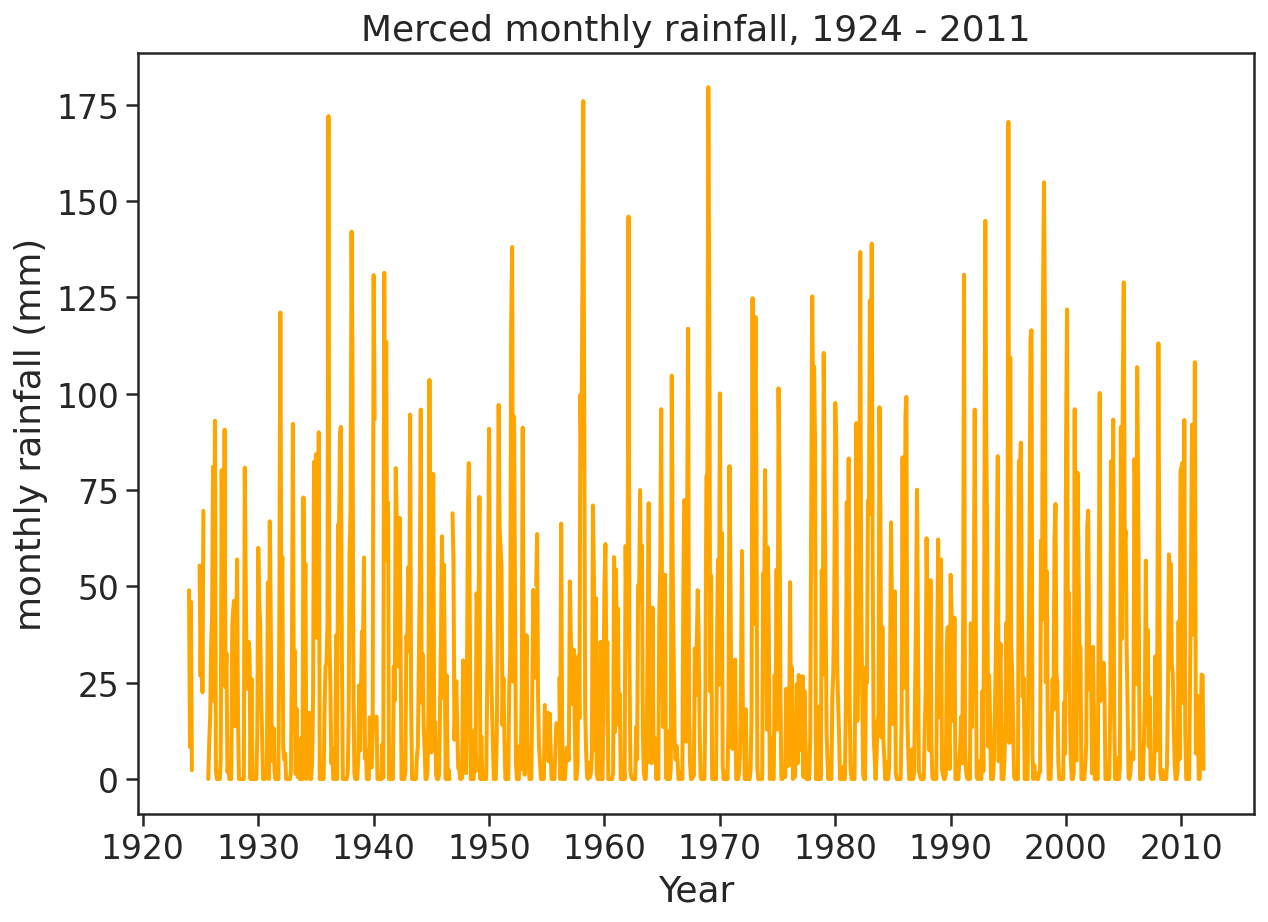

In [58]:
df_month = df_month['1924-01-01':'2011-12-01'] # creating df of the relevant data
#graph:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(df_month['PRCP'], color="orange",  linewidth=2)
ax.set(xlabel="Year",
       ylabel="monthly rainfall (mm)",
       title="Merced monthly rainfall, 1924 - 2011");

#### b. seasonality

Now we need to aggregate all data from each month, so we can calculate monthly averages by
writing a loop that takes the same month from all years and stores the mean on monthly_mean.

In [59]:
df_month_rain = df_month['PRCP']
monthly_mean = np.array([])  # empty array
month_numbers = np.arange(1,13)
month_names = [month_abbr[i] for i in month_numbers]
for i in month_numbers:
    this_month_mean= df_month_rain[df_month_rain.index.month==i].mean()
    monthly_mean=np.append(monthly_mean, this_month_mean)

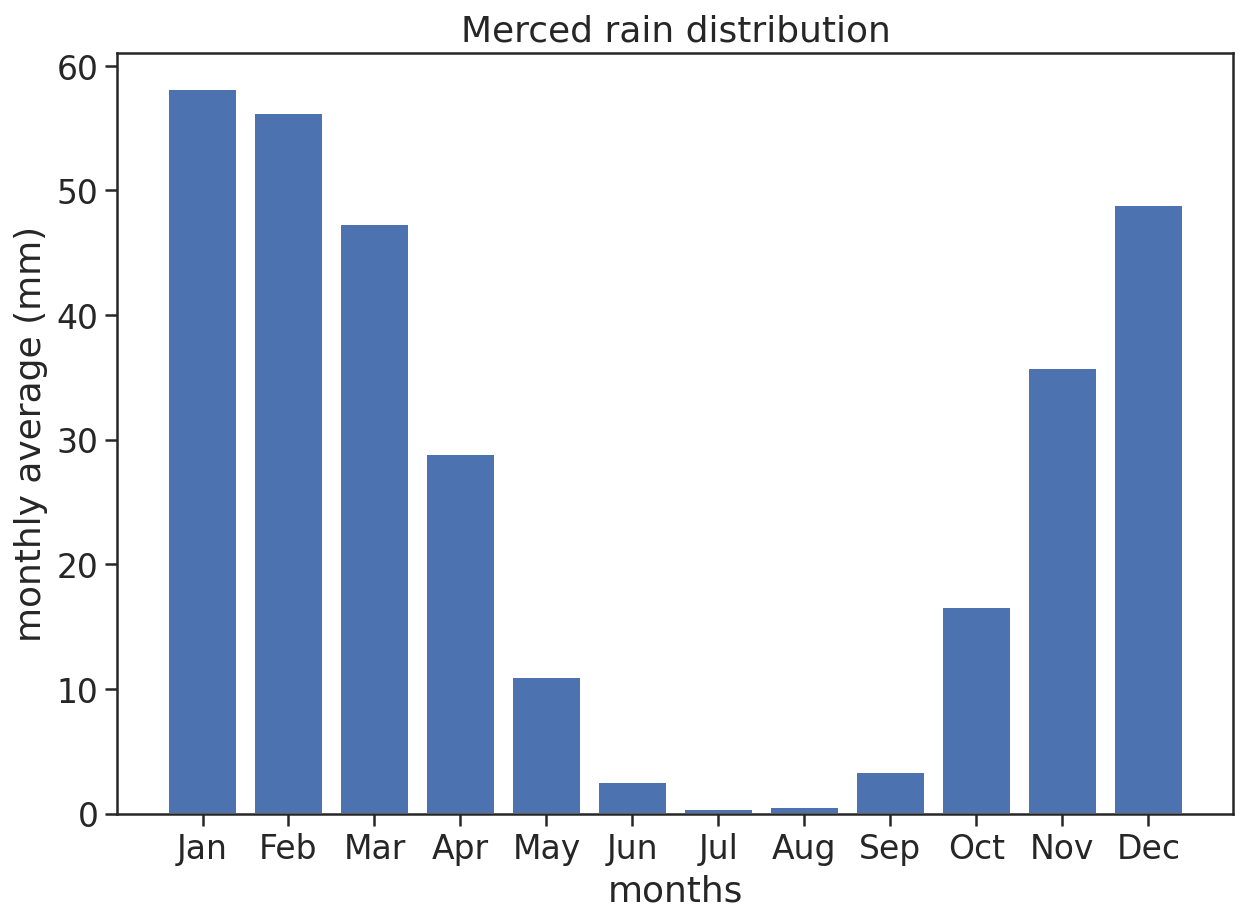

In [60]:
df_seasonal = pd.DataFrame({'monthly rainfall (mm)':monthly_mean,
                             'month names':month_names,
                             'month number':month_numbers
                            })
# Now we can plot the data:
total_seasonal = df_seasonal['monthly rainfall (mm)'].sum()

fig,ax = plt.subplots(1, 1, figsize=(10,7))
ax.bar(df_seasonal['month number'], df_seasonal['monthly rainfall (mm)'])
#ax1.plot(df_seasonal['month number']*0 + monthly_mean.mean(), linewidth=3, color="tab:orange")
ax.set(xlabel="months",
       ylabel="monthly average (mm)",
       title="Merced rain distribution",
       xticks=df_seasonal['month number'],
       xticklabels=df_seasonal['month names']);
plt.savefig("rain_distribiution_over_the_year.PNG")

Now let calculate the Walsh and Lawler **Seasonality Index**:

In [61]:
def walsh_index(df):
    X = df["monthly rainfall (mm)"]
    Ri = df["monthly rainfall (mm)"].sum()
    SI = np.sum(np.abs(X-Ri/12)) / Ri
    return SI
Merced_SI = walsh_index(df_seasonal)
Merced_SI

0.7788834749410309

#### c. interannual variability of precipitations

first lets find and plot the annual rainfall for the whole range, together with the average. for that target I will define the hydrological year at the  station (by using "resample" function) and her start will be at October. We need to exclude the first and the last year, since their data might have less that 12 months

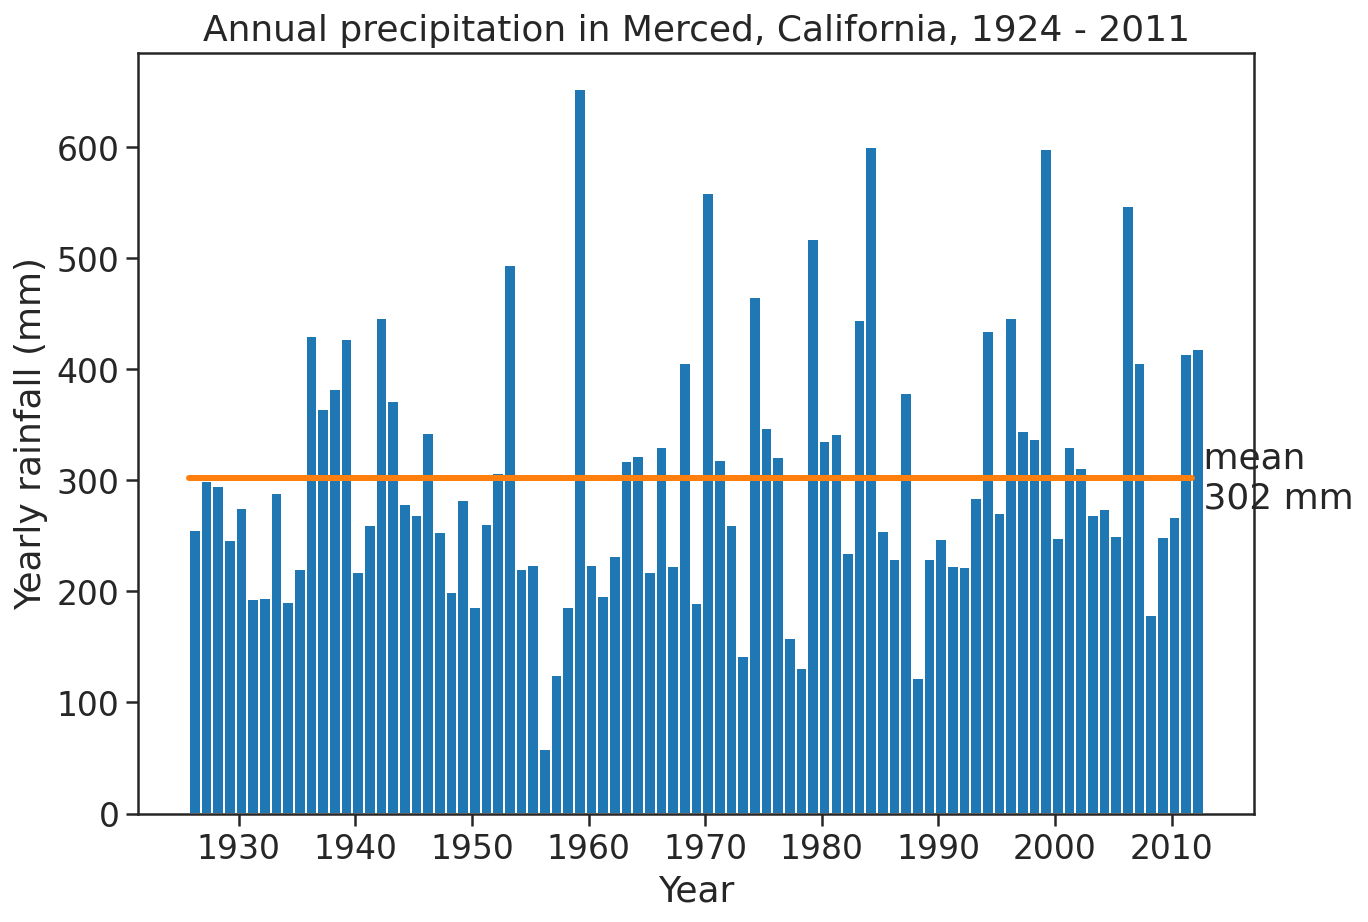

In [62]:
df_annual_rain = df_month['PRCP'].resample('A-SEP').sum().to_frame() #resample all year and defining first month
df_annual_rain.columns = ['rain (mm)'] #column name
# df_annual_rain
df_annual_rain = df_annual_rain.iloc[1:-1]

#creating graph
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(df_annual_rain.index, df_annual_rain['rain (mm)'],
       width=365, align='edge', color="tab:blue")
rain_mean_merced = df_annual_rain['rain (mm)'].mean()
ax.plot(df_annual_rain*0 + rain_mean_merced, linewidth=3, color="tab:orange")
ax.set(xlabel="Year",
       ylabel="Yearly rainfall (mm)",
       title=f"Annual precipitation in Merced, California, 1924 - 2011");
ax.text(df_annual_rain.index[-1], rain_mean_merced, " mean\n {:.0f} mm".format(rain_mean_merced),
        horizontalalignment="left", verticalalignment="center")
plt.savefig("annual_precipitation.PNG")

We will now examine the distribution of precipitation over the years around the average.
To do this we will create a histogram that will show the frequency of the annual amount of precipitation, the mean and the standard deviation:

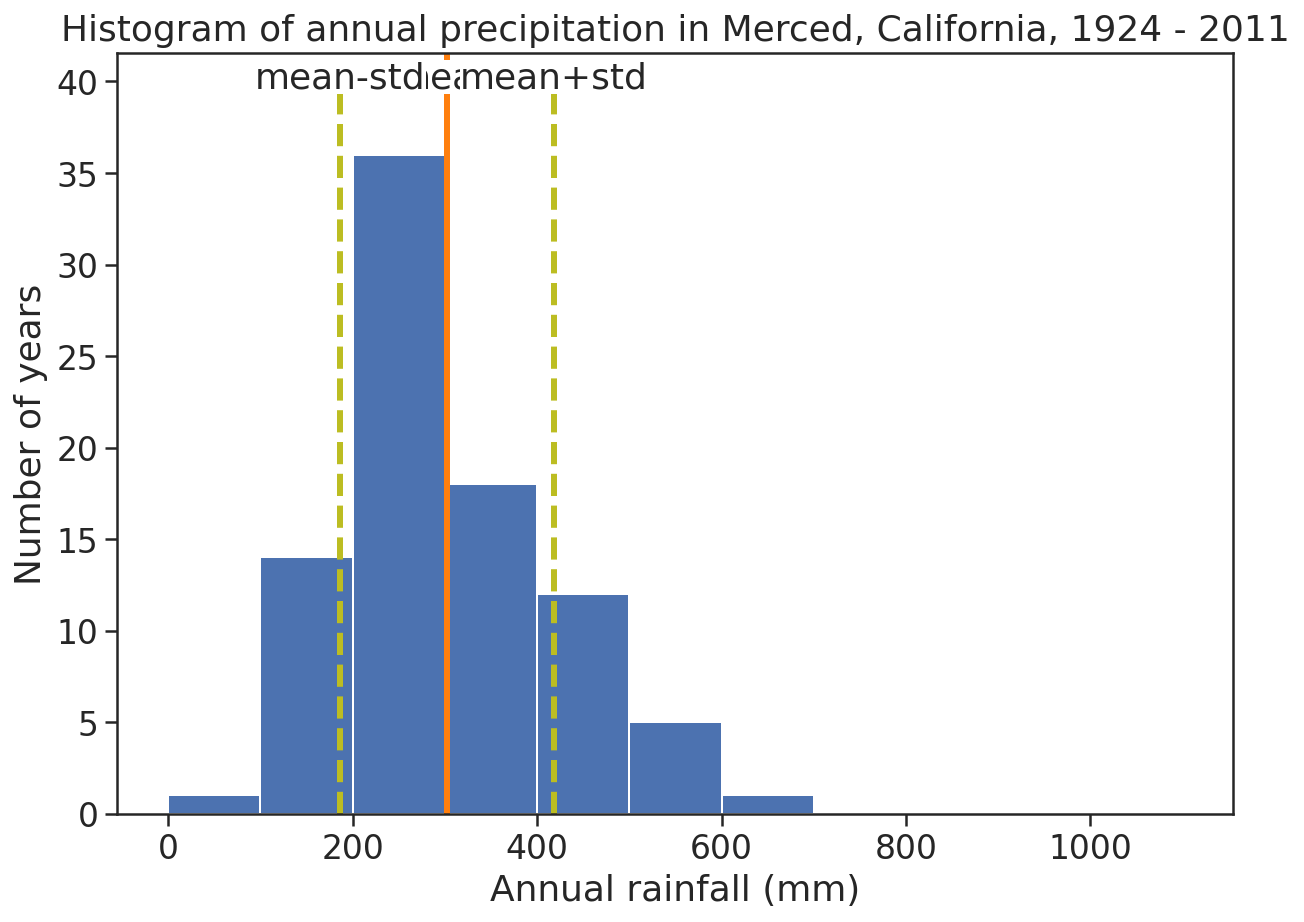

In [63]:
fig, ax = plt.subplots(figsize=(10,7))
# calculate mean and standard deviation
rain_mean = df_annual_rain['rain (mm)'].mean()
rain_std = df_annual_rain['rain (mm)'].std()
# plot histogram
b = np.arange(0, 1101, 100)  # bins from 0 to 55, width = 5
ax.hist(df_annual_rain, bins=b)
# plot vertical lines with mean, std, etc
ylim = np.array(ax.get_ylim())
ylim[1] = ylim[1]*1.1
ax.plot([rain_mean]*2, ylim, linewidth=3, color="tab:orange")
ax.plot([rain_mean+rain_std]*2, ylim, linewidth=3, linestyle="--", color="tab:olive")
ax.plot([rain_mean-rain_std]*2, ylim, linewidth=3, linestyle="--", color="tab:olive")
ax.set_ylim(ylim)
# write mean, std, etc
ax.text(rain_mean, ylim[1]*0.99, "mean",
        horizontalalignment="center",
        verticalalignment="top",
        bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
ax.text(rain_mean+rain_std, ylim[1]*0.99, "mean+std",
        horizontalalignment="center",
        verticalalignment="top",
        bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
ax.text(rain_mean-rain_std, ylim[1]*0.99, "mean-std",
        horizontalalignment="center",
        verticalalignment="top",
        bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
# adjust labels, ticks, title, limits, etc
ax.set_title("Histogram of annual precipitation in Merced, California, 1924 - 2011")
ax.set_xlabel("Annual rainfall (mm)")
ax.set_ylabel("Number of years")
# save figure
plt.savefig("histogram_merced_with_mean_and_std.png")

In order to be precise we consider the **coefficient of variance (CV)**, the ratio between the std and the mean. Its value will show us how dense the distribution is around the mean (we will assume this is a normal distribution):

In [64]:
CV = rain_std / rain_mean
print("CV(Merced) = ",float(CV))

CV(Merced) =  0.38264403654650875


In [65]:
import altair as alt
from vega_datasets import data
# Altair only recognizes column data; it ignores index values. You can plot the index data by first resetting the index
source = df_annual_rain.reset_index()
brush = alt.selection(type='interval', encodings=['x'])
bars = alt.Chart().mark_bar().encode(
    x=alt.X('DATE:T', axis=alt.Axis(title='date')),
    y=alt.Y('rain (mm):Q',  axis=alt.Axis(title='annual precipitation (mm) and average')),
    opacity=alt.condition(brush, alt.OpacityValue(1), alt.OpacityValue(0.2)),
).add_selection(
    brush
).properties(
    title='Select year range and drag for rolling average of annual precipitation in Merced, California'
).properties(
    width=600,
    height=400
)
line = alt.Chart().mark_rule(color='orange').encode(
    y='mean(rain (mm)):Q',
    size=alt.SizeValue(3)
).transform_filter(
    brush
)
alt.layer(bars, line, data=source)

alt.LayerChart(...)

To see if we have a trend over the years we will create last graph. In order to produce the following graph we set an average for each 25 year range and presented the dates next to each other by dates to see if there was a trend.

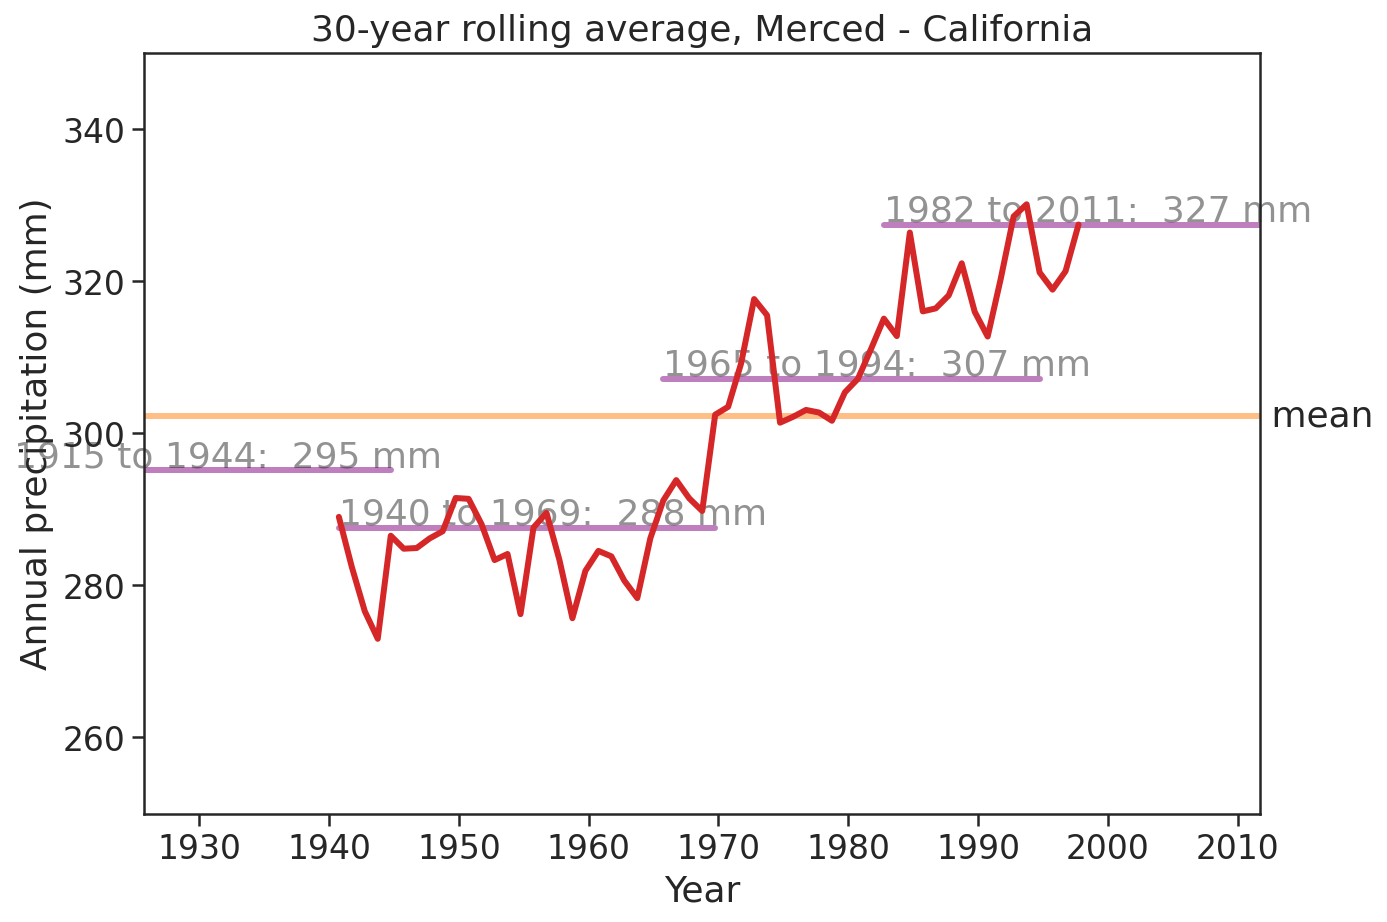

In [66]:
fig, ax = plt.subplots(figsize=(10,7))

rolling_mean = df_annual_rain.rolling(30, center=True).mean()
ax.plot(rolling_mean, linewidth=3, color="tab:red", zorder=5)

ax.set_title("30-year rolling average, Merced - California")
ax.set_xlabel("Year")
ax.set_ylabel("Annual precipitation (mm)")

# windows of length 60 years
windows = [[x,x+29] for x in [1915,1940,1965,1982]]
for window in windows:
    start_date = f"{window[0]:d}-09-30"
    end_date = f"{window[1]:d}-09-30"
    window_mean = df_annual_rain['rain (mm)'][start_date:end_date].mean()
    ax.plot(df_annual_rain[start_date:end_date]*0+window_mean, color="purple", linewidth=3, alpha=0.5)
    ax.text(start_date, window_mean+0.5, f"{window[0]} to {window[1]}:  {window_mean:.0f} mm", alpha=0.5)
ax.set_ylim([250, 350])

# plot mean
ax.plot(df_annual_rain*0 + rain_mean, linewidth=3, color="tab:orange", alpha=0.5)
ax.text(df_annual_rain.index[-1], rain_mean, " mean".format(rain_mean),
        horizontalalignment="left", verticalalignment="center")
ax.set_xlim([df_annual_rain.index[0], df_annual_rain.index[-1]])

# save figure
plt.savefig("rolling_average_Merced.png")

#### d. extreme precipitation events and return periods.
for this calculations we will work on the daily data of the station. so lets start with reading the data and organized it. we will change the units to mm by dividing the PRCP column in 10 and set the date to be the index:

In [67]:
df = pd.read_csv('MERCED_daily.csv', sep=",")
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df['PRCP'] = df['PRCP']/10
# df

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (17,19,27,29,31,33,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 1.0, 'Merced daily rain')

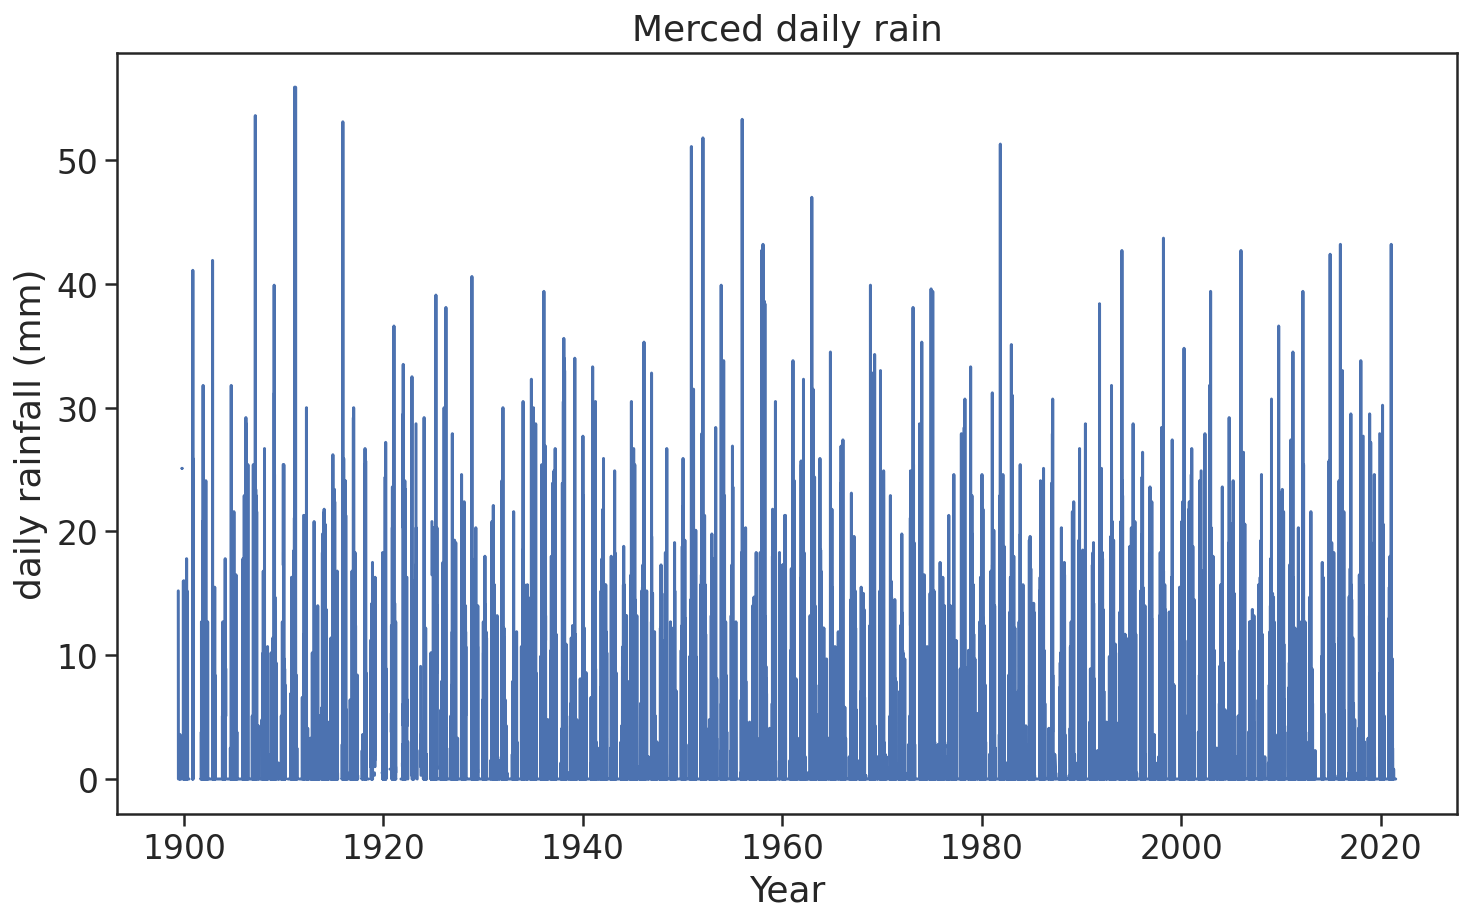

In [68]:
# lets see the data:
plt.plot(df['PRCP'])
plt.xlabel("Year")
plt.ylabel("daily rainfall (mm)")
plt.title("Merced daily rain")

here it looks that we have the full data so we will analyze all the data because we dont need to compare this analiysis the the privious so we now have more data to analyse and its more relyable:

From an initial look at the data it can be seen that we have no very exstreme event over the years in Merced but in the 50s there was a some massive rain events. (Over 40mm per day). We will try to quantify this information so that we can understand more accurately return period. Now First we need to find the annual maximum for each hydrological year (October=first). we will use resample function as we did before:

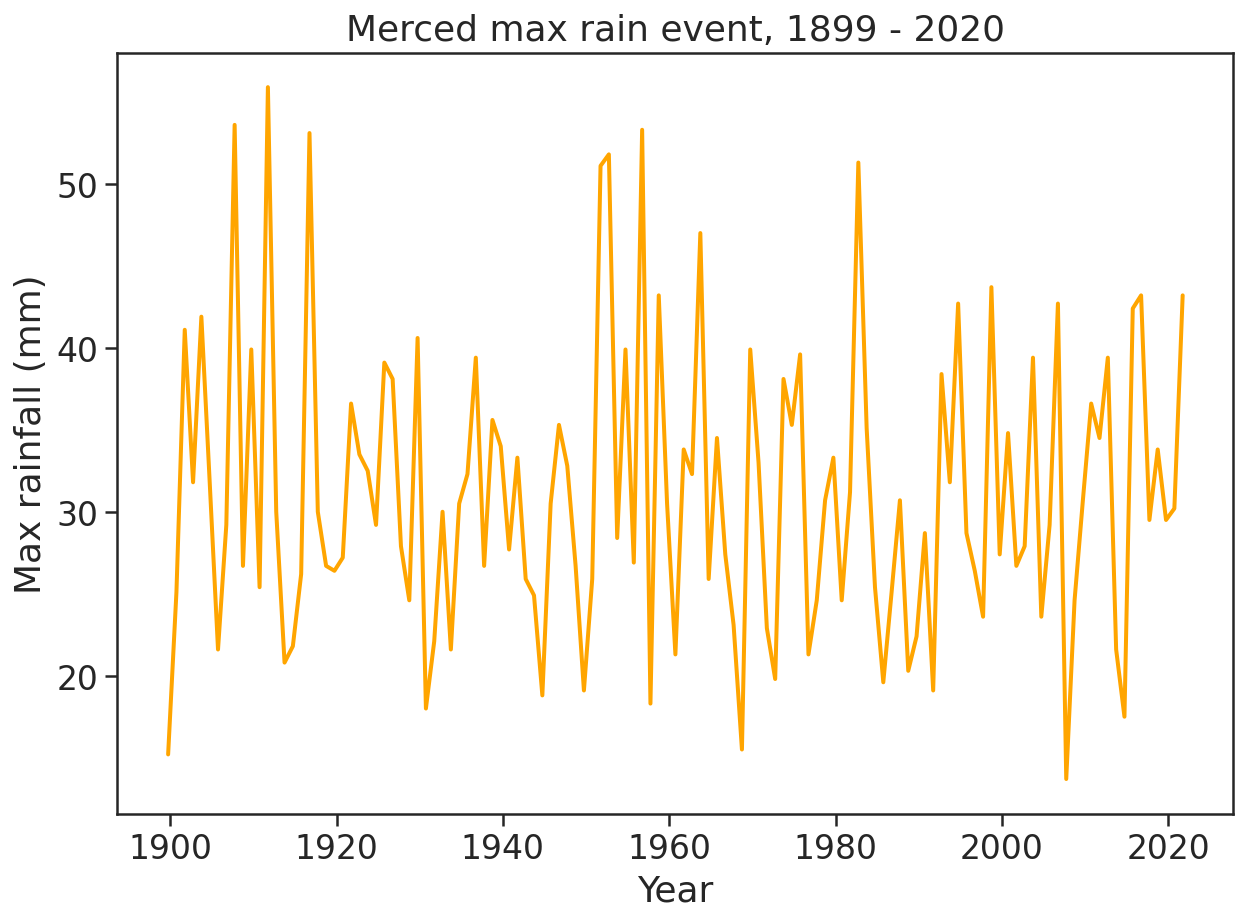

In [69]:
#resample the data and find the maximum for all year:
max_annual = (df['PRCP'].resample('A-SEP')
                        .max()
                        .to_frame()
             )

# graph:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(max_annual, color="orange",  linewidth=2)
ax.set(xlabel="Year",
       ylabel="Max rainfall (mm)",
       title="Merced max rain event, 1899 - 2020");

##### pdf & cdf
Now lets make two graphs:

a) the histogram for the annual maximum (pdf)

b) the cumulative probability (cdf).

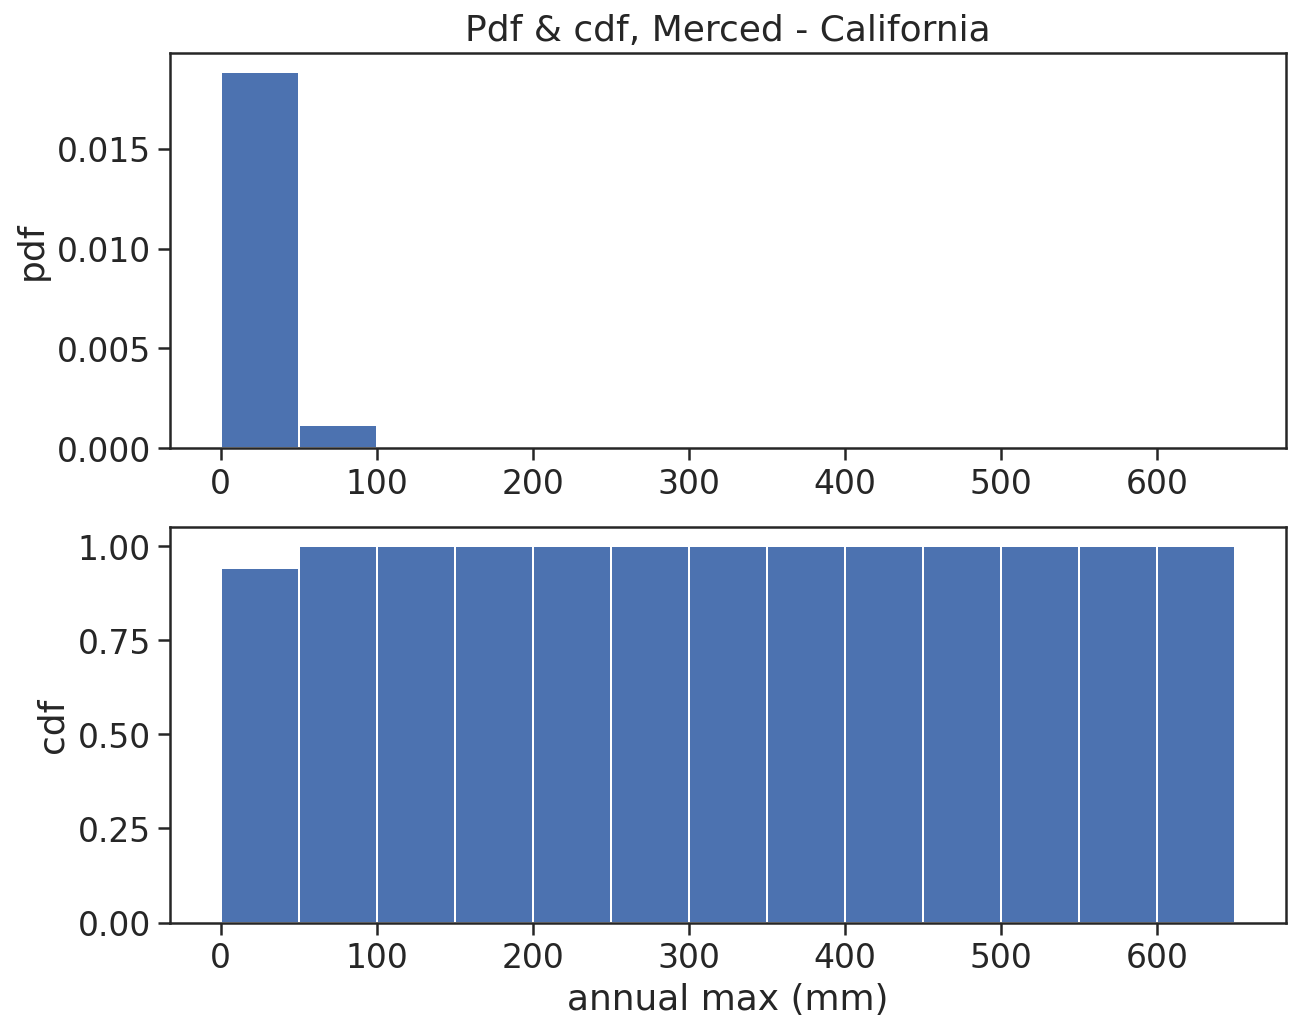

In [70]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
#taking the max values of partcipitation:
h=max_annual['PRCP'].values
#creating histograma, defining "density = true" to get the probability instead of quntity
ax1.hist(h, bins=np.arange(0,700,50), density=True)
#creating cdf - defining "cumulative =1" to accept the probability that we will not exceed the current range
ax2.hist(h, bins=np.arange(0,700,50), density=True, cumulative=1)
ax1.set_title("Pdf & cdf, Merced - California")
ax1.set(ylabel="pdf")
ax2.set(xlabel="annual max (mm)",
        ylabel="cdf",        )
plt.savefig("pdf_cdf.png")

##### Weibull plotting position & Return period:
We will present the graphs on a logarithmic scale. We will then take only the linear part by using a liner fit to produce a linear prediction equation and return period:

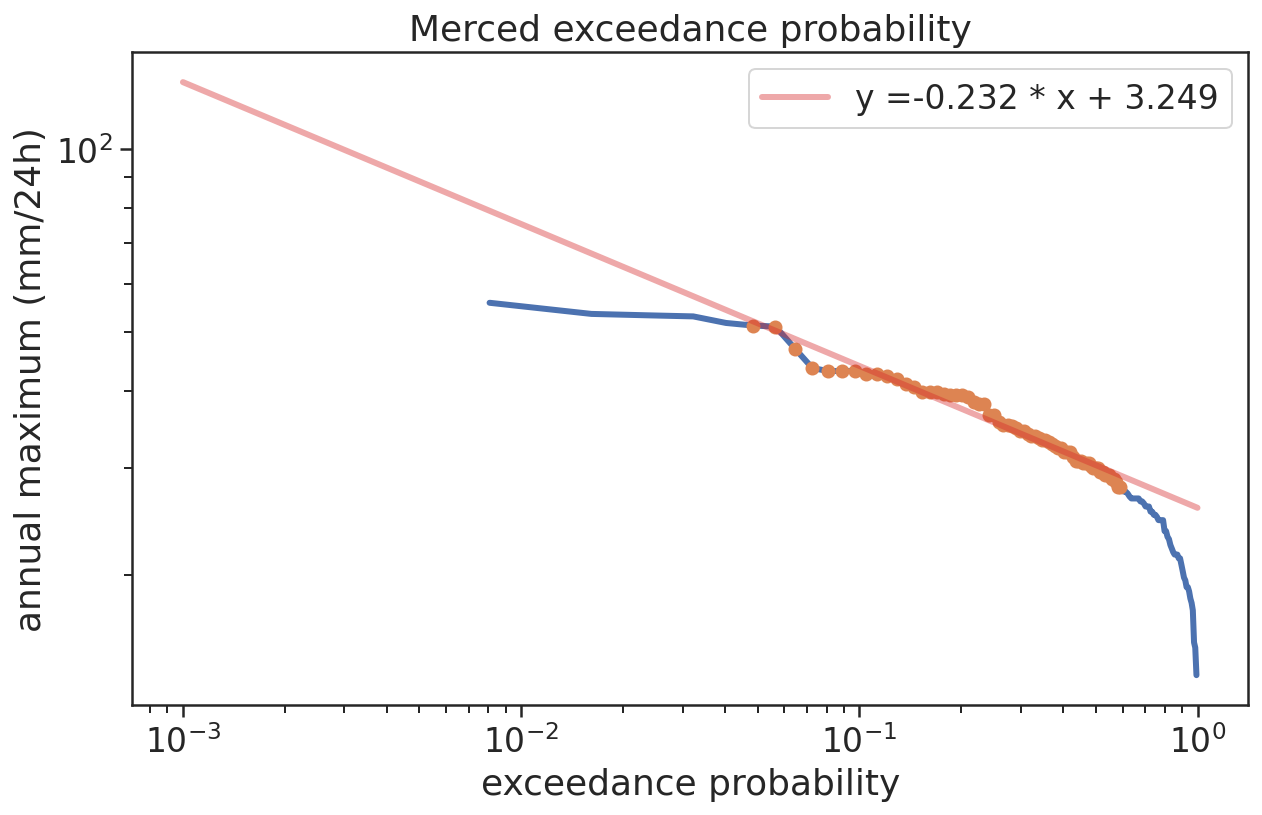

In [71]:
#sorting the values of PRCP column from the low to high (ascending=True)
max_annual = max_annual.sort_values(by=['PRCP'], ascending=True)
#fefining n,m,Pm, Tr and adding colunms to max_anual:
n = len (max_annual)
max_annual['m'] = np.arange(1,n+1)
max_annual['Pm'] = max_annual['m']/(n+1)
#we want the exceedance probability so we need to write it like this:
max_annual['Tr'] = 1/(1-max_annual['Pm'])
m = max_annual['m']
Pm = m / (n+1)
Tr = 1 / (1 - Pm)
#max_annual
fig, ax = plt.subplots(figsize=(10, 6))

depth = max_annual['PRCP'].values
exc_prob = (1-Pm).values

ax.plot(exc_prob, depth, lw=3)
#only the leaner part (after some iterations, without the non-leaner data at the beginning and at the end):
exclude = 50
depth_tofit = depth[exclude:-5]
exc_prob_tofit = exc_prob[exclude:-5]
ax.plot(exc_prob_tofit, depth_tofit, 'o')

#labels and logaritmic scale:
ax.set_title("Merced exceedance probability")
ax.set(ylabel="annual maximum (mm/24h)",
       xlabel="exceedance probability",
       xscale="log",
       yscale="log",
      )
#Now lets make leaner fit using (slope, intercept):
exc_prob_tofit_log = np.log(exc_prob_tofit) #log for the (1-Pm) values
depth_tofit_log = np.log(depth_tofit) #log for the PRCP values
slope, intercept = np.polyfit(exc_prob_tofit_log, depth_tofit_log, 1) #we are writing "1" cecause we want leaner equation

def equation(p):
    return np.exp(slope*np.log(p) + intercept) #A function that returns y=exp(log(x)+intercept)
prob = [1e-3,1-1e-3]
ax.plot(prob, equation(prob), lw=3, color="tab:red", alpha=0.4,label = "y =-0.232 * x + 3.249")
ax.legend()

now lets make a graph of return period:

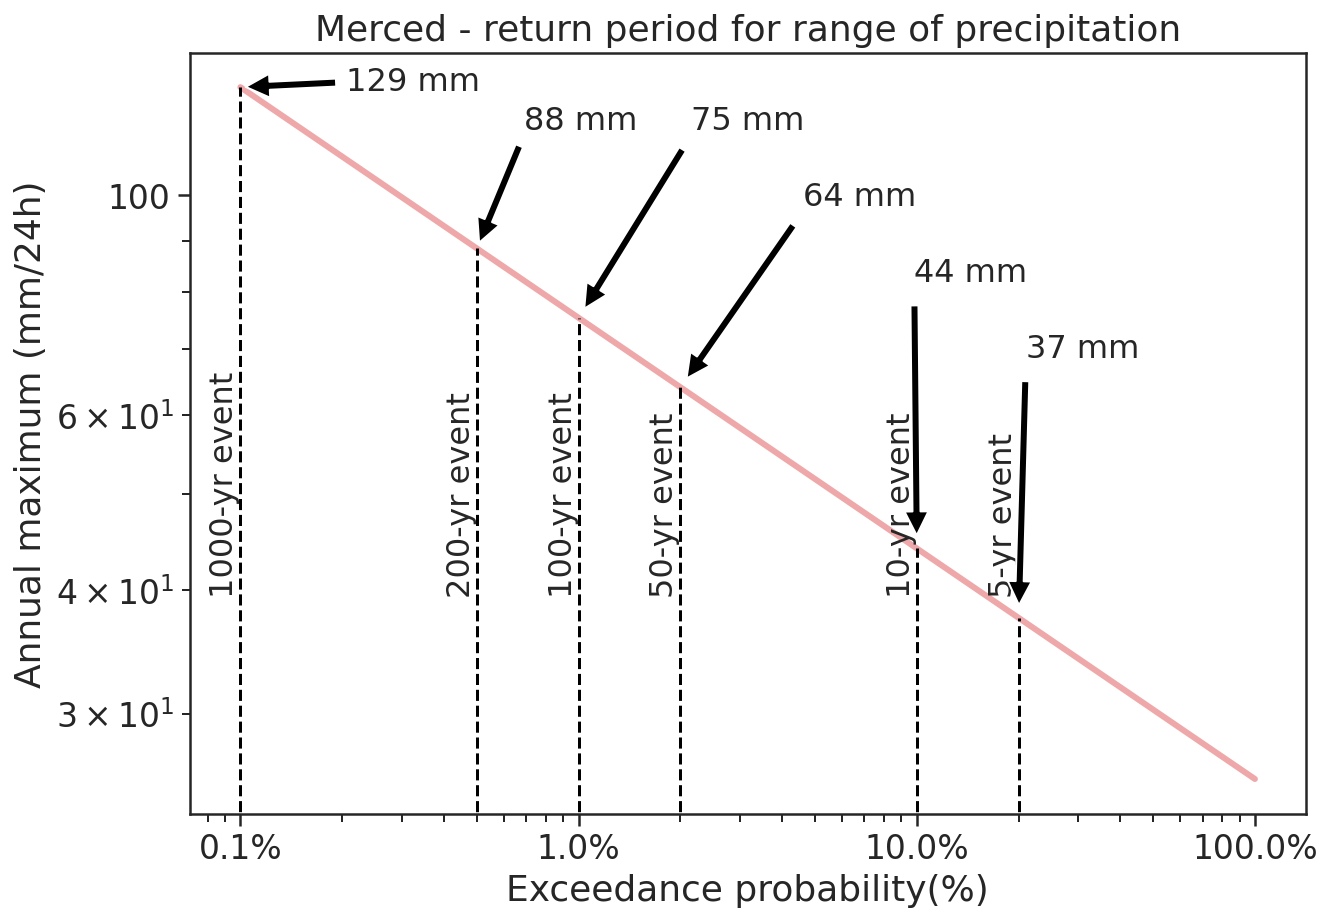

In [72]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(10,7))
prob = [1e-3,1-1e-3]

def equation(p):
    return np.exp(slope*np.log(p) + intercept)

ax.plot(prob, equation(prob), lw=3, color="tab:red", alpha=0.4)
one_in_x_years = np.array([5, 10, 50, 100, 200, 1000])

for y in one_in_x_years:
    ax.plot([1/y]*2, [0, equation(1/y)], color="black", ls="--")
    ax.text(1/y, 40, f"{y}-yr event", rotation=90, ha="right", fontsize=16)
ax.set(ylabel="Annual maximum (mm/24h)",
       xlabel="Exceedance probability(%)")
ax.set_title("Merced - return period for range of precipitation")
ax.set_xticks([0.1, 0.2,0.5, 1.0])
ax.set_yticks([10, 20, 50, 100, 200, 500])
ax.set_xscale("log")
ax.set_yscale("log")
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.1f}%'.format(y*100)))
ax.annotate(f"{equation(1/5):.0f} mm",
            xy=(1/5, equation(1/5)), xycoords='data',
             xytext=(0.8, 0.6), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f"{equation(1/10):.0f} mm",
            xy=(1/10, equation(1/10)), xycoords='data',
             xytext=(0.7, 0.7), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f"{equation(1/50):.0f} mm",
            xy=(1/50, equation(1/50)), xycoords='data',
             xytext=(0.6, 0.8), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f"{equation(1/100):.0f} mm",
            xy=(1/100, equation(1/100)), xycoords='data',
             xytext=(0.5, 0.9), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f"{equation(1/200):.0f} mm",
            xy=(1/200, equation(1/200)), xycoords='data',
             xytext=(0.35, 0.9), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f"{equation(1/1000):.0f} mm",
            xy=(1/1000, equation(1/1000)), xycoords='data',
             xytext=(0.2, 0.95), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.savefig("return_period.png")

## 2. Evapotranspiration

#### a. import and organize the data

We will represent ET for 3 different years. The code is the same for everyone. We will perform the process 3 times: once for each year. Finally we will present the 3 results.

In [73]:
# data file of all the years 2013,2014,2016
# data_file = "CRNS0101-05-2013-CA_Merced_23_WSW_2013.txt"
# data_file = "CRNS0101-05-2014-CA_Merced_23_WSW.txt"
data_file = "CRNS0101-05-2016-CA_Merced_23_WSW.txt"
df_et = pd.read_csv(data_file,
                 header=None,                      # no headers needed, we'll do that later
                 delim_whitespace=True,            # blank spaces separate between columns
                 na_values=["-99.000", "-9999.0"]  # substitute these values for missing (NaN) values
                )
headers = pd.read_csv("HEADERS.txt",    # load headers file
                      header=1,                    # skip the first [0] line
                      delim_whitespace=True
                     )
df_et.columns = headers.columns                       # rename df columns with headers columns
# LST = local standard time
df_et["LST_TIME"] = [f"{x:04d}" for x in df_et["LST_TIME"]]  # time needs padding of zeros, then convert to string
df_et['LST_DATE'] = df_et['LST_DATE'].astype(str)            # convert date into string
df_et['datetime'] = df_et['LST_DATE'] + ' ' + df_et['LST_TIME'] # combine date+time into datetime
df_et['datetime'] = pd.to_datetime(df_et['datetime'])        # interpret datetime
df_et = df_et.set_index('datetime')                          # make datetime the index
# df_et

According to the [station details](https://www.ncdc.noaa.gov/cdo-web/datasets/GSOM/stations/GHCND:USC00045532/detail), its height above sea level is 46.9 (meters), so we will add another column of air pressure (Kpa) according to the formula:

$ P (Kpa) =101.3−0.01055*H(m) $

In [74]:
H = 46.9 #[m]
df_et["AIR_PRESSURE"] =101.3 -(H*0.01055)
# df_et["AIR_PRESSURE"]        #uncomment to see the value

An initial graph is made to make sure we do not have missing information (uncomment the cell to see the graphs):

In [75]:
# # solar radiation:
# fig, ax = plt.subplots(1, figsize=(10,7))
# ax.plot(df_et["SOLAR_RADIATION"], color="orange",  linewidth=2)
# ax.set(xlabel="date",
#        ylabel="solar radiation [W/m^2] ",
#        title="Merced solar radiation");

# # wind speed
# fig, ax = plt.subplots(1, figsize=(10,7))
# ax.plot(df_et["WIND_1_5"], color="blue",  linewidth=2)
# ax.set(xlabel="date",
#        ylabel="wind speed  [m/s] ",
#        title="Merced wind speed");

# # air temperture
# fig, ax = plt.subplots(1, figsize=(10,7))
# ax.plot(df_et["AIR_TEMPERATURE"], color="red",  linewidth=2)
# ax.set(xlabel="date",
#        ylabel="air temperture  [Celsius] ",
#        title="Merced air temperture");

# # RELATIVE_HUMIDITY
# fig, ax = plt.subplots(1, figsize=(10,7))
# ax.plot(df_et["RELATIVE_HUMIDITY"], color="green",  linewidth=2)
# ax.set(xlabel="date",
#        ylabel="relative humidity  [%] ",
#        title="Merced relative humidity");

# # plt.plot(df_cal["RELATIVE_HUMIDITY"])

In [76]:
# changing the negative values into 0 :
df_et["AIR_TEMPERATURE"][df_et["AIR_TEMPERATURE"]<0] = 0
df_et["RELATIVE_HUMIDITY"][df_et["RELATIVE_HUMIDITY"]<0] = 0

/tmp/ipykernel_347/858654172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_et["AIR_TEMPERATURE"][df_et["AIR_TEMPERATURE"]<0] = 0
/tmp/ipykernel_347/858654172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_et["RELATIVE_HUMIDITY"][df_et["RELATIVE_HUMIDITY"]<0] = 0


#### b. Thonthweit estimation

we will use the monthly data to calculate Thornthweit estimation to the all period of the available data:
first, lets make a new dataframe, df_th, that stores monthly temperatures means using `resample` function.

In [77]:
# monthly data merced
df_th = (df_month["TAVG"].resample('MS')  # MS assigns mean to first day in the month
                .mean()
                .to_frame()
        )
# we now add 14 days to the index, so that all monthly data is in the middle of the month
# not really necessary, makes plot look better
df_th.index = df_th.index + pd.DateOffset(days=14)
# plt.plot(df_th) #uncomment to see the graph
# df_th           #uncomment to see the new DataFrame

Now we can Calculate $I$, then $a$, and finally $E_p$. we will add $E_p$ as a new column in df_th.

In [78]:
# we have to calculate the potential ET per every year:
for year in range(1924,2011):
    this_year = df_th[df_th.index.year ==year]
    I = np.sum( (this_year['TAVG']/5)**(1.514) ) # Preparing "I" for the Thornthwaite equation
    a = 6.75e-7 * I*3 - 7.71e-5 * I*2 + 1.792e-2 * I + 0.49239 # Preparing "a" for the Thornthwaite equation
    df_th.loc[df_th.index.year==year, 'Ep'] = 16*((10*this_year['TAVG']/I)**a)
df_th['Ep'] = 16*((10*df_th['TAVG']/I)**a)
df_th['Ep'] = df_th['Ep'].replace(np.nan, 0) #replacing NaN with 0
# df_th

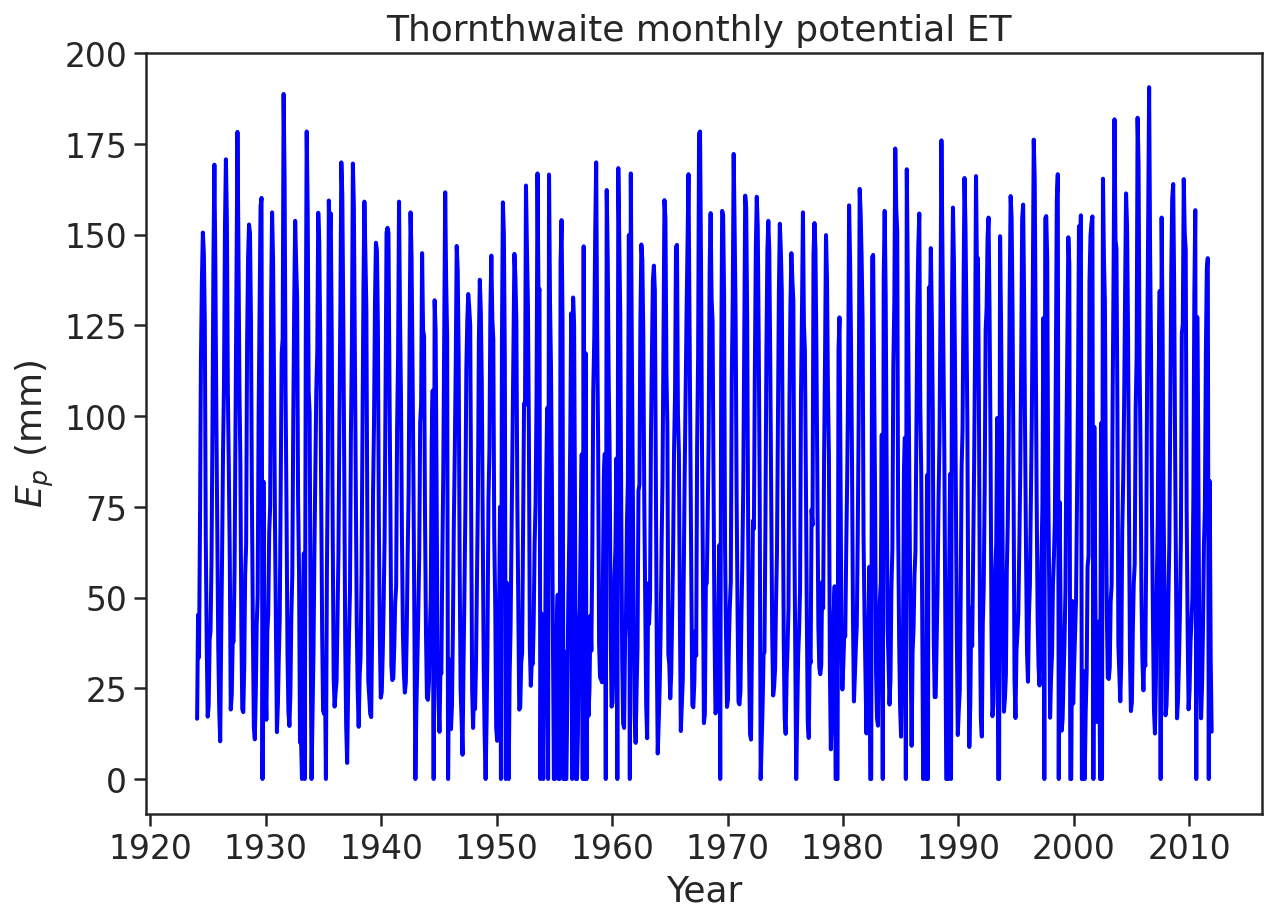

In [79]:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(df_th['Ep'], color="blue",  linewidth=2)
ax.set(xlabel="Year",
       ylabel=r"$E_p$ (mm)",
       title="Thornthwaite monthly potential ET ");
plt.savefig("Thornthwaite_monthly.png")

Now we have the monthly ET, let calculate the annual ET of every year by the same procces:

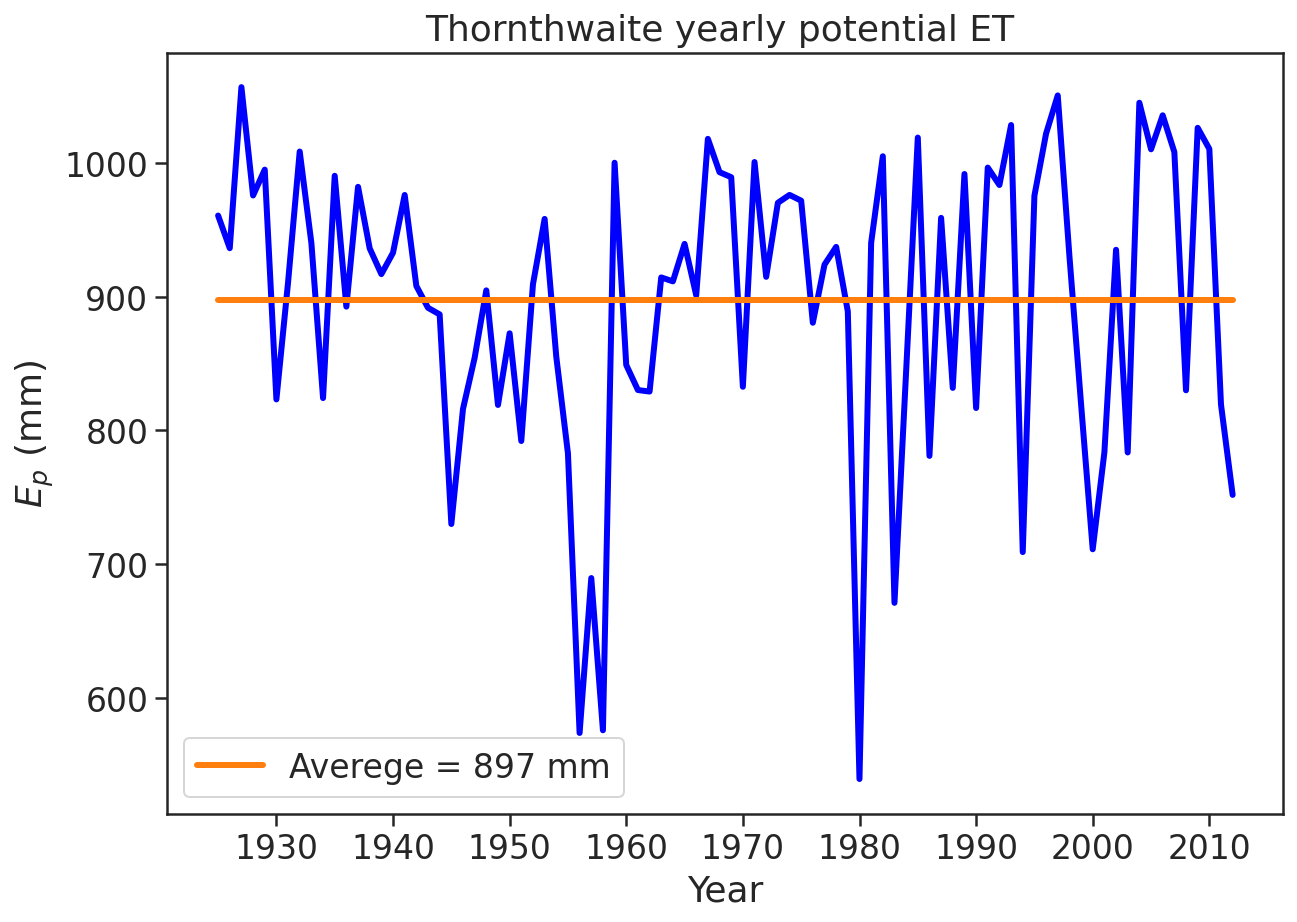

In [80]:
df_th_annual = (df_th['Ep'].resample('Y').sum().to_frame()) # resample the ET from month into year and sum for every year

# graph:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(df_th_annual, color="blue",  linewidth=3)
et_mean = df_th_annual.mean()
ax.plot(df_th_annual*0 + et_mean, linewidth=3, color="tab:orange",label="Averege = 897 mm") 
ax.set(xlabel="Year",
       ylabel=r"$E_p$ (mm)",
       title="Thornthwaite yearly potential ET ");
ax.legend()
plt.savefig("Thornthwaite_yearly.png")

In [81]:
# values to present:
# df_th_annual.std()
# df_th_annual.mean()
# df_th_annual.min()
# df_th_annual.max()
# df_th['Ep'].mean()
# df_th['Ep'].std()
# df_th['Ep'].min()
# df_th['Ep'].max()

#### c. Penman eqution

We will create new DataFrame called "df_pen" and we will create columns for the various variables:

In [82]:
#resampling sub-hourly data over same day and taking mean, to obtain daily averages:

df_pen = (df_et['AIR_TEMPERATURE'].resample('D')
                 .mean()
                 .to_frame()
         )
df_pen['u'] = (df_et["WIND_1_5"].resample('D')
                               .mean()
              )
df_pen['P'] = (df_et["AIR_PRESSURE"].resample('D')
                             .mean()
              )
df_pen['RH'] = (df_et['RELATIVE_HUMIDITY'].resample('D')
                                           .mean()
               )
df_pen['daily_radiation_MJ/m^2*day'] = (df_et['SOLAR_RADIATION'].resample('D')
                                           .mean()
               )/(1000000/86000)                          #convert from w/(m^2*day) into MJ/(m^2*day)
# df_pen #uncomment to see the full dataFrame

With average $T$ for every day of the year, we can now calculate daily latent heat of vaporization $\lambda$, the slope of the saturation-vapor pressure-temperature curve $\Delta$, and the heat flux density to the ground $G$.We will add each of these to dataframe `df_pen`.  

Lets also calculate the wind function using the data for wind speed, and add this to `df_pen`:

In [83]:
def lambda_latent_heat(T):
    """daily latent heat of vaporization (MJ/kg)"""
    return 2.501 - 2.361e-3*T

def Delta(T):
    """slope of saturation-vapor curve (kPa/°C)"""
    return 0.2000*(0.00738*T + 0.8072)**7 - 0.000116

def G(T):
    """heat flux density to the ground, G (MJ/m2/d)"""
    return 4.2*np.gradient(T.values)      #It's basically a derivative:)

cp = 0.001013  # (MJ kg−1 °C−1) 
df_pen['lambda'] = lambda_latent_heat(df_pen['AIR_TEMPERATURE'])
df_pen['Delta'] = Delta(df_pen['AIR_TEMPERATURE'])
df_pen['G'] = G(df_pen['AIR_TEMPERATURE'])
df_pen['gamma'] = (cp*df_pen["P"])/(0.622*df_pen['lambda'])
df_pen['f_wind'] = 1.0 + 0.53 * df_pen['u']
# df_pen                               #uncomment to see the DataFrame

It's time to calculate net radiation $R_n$. The [monthly mean solar radiation](https://yairmau.com/jupyter/2020/02/01/evapotranspiration-lecture.html) $R_{so}$ for latitude 37.2888 degrees (which is the latitude of Merced) is
`[14.95,19.55, 24.58,29.31, 32.11, 33.49, 32.66, 29.18, 23.74, 18.42, 13.52, 10.76]` (MJ m$^{-2}$ d$^{-1}$).

We will add a new column `Rso_monthly` to `df_pen`, where each day has the appropriate $R_{so}$ given by the data above. 
And also we will add a new columns `Rs` with the global radiation.

In [84]:
# Rso: mean solar radiation from a cloudless sky (based on latitude)
# MJ/m2/d
Rso_monthly = np.array([14.95,19.55, 24.58,29.31, 32.11, 33.49, 32.66, 29.18, 23.74, 18.42, 13.52, 10.76])

# creating empty columns
df_pen["Rso_monthly"] = ""

# every day in the month will have the same values for Rso
for i in range(12):
    df_pen.loc[df_pen.index.month==(i+1), "Rso_monthly"] = Rso_monthly[i]
# df_pen                                       #uncomment to see the DataFrame


We will add a new column `Rn` to `df_pen` dataframe:

In [85]:
df_pen['T(k)'] = df_pen['AIR_TEMPERATURE']+273.15
sigma = 4.903e-9
df_pen["emissivity"] = -0.02 +0.261*np.exp(-7.77e-4*(df_pen['AIR_TEMPERATURE']**2))
df_pen["Rbo"] = df_pen["emissivity"]*sigma*(df_pen['T(k)']**4)
a = 1.1
b = -0.1
df_pen["Rb"] = (a*df_pen['daily_radiation_MJ/m^2*day']/df_pen['Rso_monthly'] + b)*df_pen['Rbo']
albedo = 0.336
df_pen['Rn'] = (1-albedo)*df_pen['daily_radiation_MJ/m^2*day']-df_pen['Rb']
# df_pen                                       #uncomment to see the DataFrame

Now lets calculate the vapor pressure deficit, VPD, add a new column to `df_pen`.

$$e_d = e_s\cdot \frac{RH}{100}$$

$$e_s = \exp\left(\frac{16.78\,T-116.9}{T+237.3}\right)$$

In [86]:
# vapor pressure deficit = VPD
def vp_sat(T):
    return np.exp((16.78*T - 116.9)/(T + 237.3)) 
df_pen['es'] = vp_sat(df_pen['AIR_TEMPERATURE'])
df_pen['ed'] = df_pen['es'] * df_pen['RH'] / 100
df_pen['VPD'] = df_pen['es'] - df_pen['ed']
# df_pen                                       #uncomment to see the DataFrame

Now that all variables have been defined, daily E_penman can be calculated. 

$$
\begin{equation}
E_{tp} = \frac{\Delta}{\Delta+\gamma}Q_{ne}+ \frac{\gamma}{\Delta+\gamma}E_A
\end{equation}
$$

$Q_n$ is the available energy flux density:

$$
\begin{equation}
Q_n = R_n - G,
\end{equation}
$$

and $E_A$ is the drying power of the air:

$$
\begin{equation}
E_A = f_e(u)\cdot\text{VPD}
\end{equation}
$$

Lets add a new column `E_penman` to `df_pen`:

In [87]:
df_pen['Qn'] = df_pen['Rn'] - df_pen['G']
df_pen['Ea'] = 6.43*(1+0.53*df_pen['u'])*df_pen['VPD']
df_pen['Etp'] = df_pen['Qn']*(df_pen['Delta']/(df_pen['Delta']+df_pen['gamma'])) + df_pen['Ea']*(df_pen['gamma']/(df_pen['Delta']+df_pen['gamma']))
df_pen['E_penman'] = df_pen['Etp']*(1/df_pen['lambda'])
df_pen['E_penman'][df_pen['E_penman']<0] = 0 # all the nagetive values into 0
# df_pen

/tmp/ipykernel_347/3445023978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pen['E_penman'][df_pen['E_penman']<0] = 0 # all the nagetive values into 0


that's it, lets do the same procces to the other years and plot the results:

In [88]:
# for 2014
data_file = "CRNS0101-05-2014-CA_Merced_23_WSW.txt"
df_et2014 = pd.read_csv(data_file,
                 header=None,                      # no headers needed, we'll do that later
                 delim_whitespace=True,            # blank spaces separate between columns
                 na_values=["-99.000", "-9999.0"]  # substitute these values for missing (NaN) values
                )
headers = pd.read_csv("HEADERS.txt",    # load headers file
                      header=1,                    # skip the first [0] line
                      delim_whitespace=True
                     )
df_et2014.columns = headers.columns                       # rename df columns with headers columns
# LST = local standard time
df_et2014["LST_TIME"] = [f"{x:04d}" for x in df_et2014["LST_TIME"]]  # time needs padding of zeros, then convert to string
df_et2014['LST_DATE'] = df_et2014['LST_DATE'].astype(str)            # convert date into string
df_et2014['datetime'] = df_et2014['LST_DATE'] + ' ' + df_et2014['LST_TIME'] # combine date+time into datetime
df_et2014['datetime'] = pd.to_datetime(df_et2014['datetime'])        # interpret datetime
df_et2014 = df_et2014.set_index('datetime')                          # make datetime the index
df_et2014["AIR_PRESSURE"] =101.3 -(H*0.01055)
df_et2014["AIR_TEMPERATURE"][df_et2014["AIR_TEMPERATURE"]<0] = 0
df_et2014["RELATIVE_HUMIDITY"][df_et2014["RELATIVE_HUMIDITY"]<0] = 0
#resampling sub-hourly data over same day and taking mean, to obtain daily averages:

df_pen2014 = (df_et2014['AIR_TEMPERATURE'].resample('D')
                 .mean()
                 .to_frame()
         )
df_pen2014['u'] = (df_et2014["WIND_1_5"].resample('D')
                               .mean()
              )
df_pen2014['P'] = (df_et2014["AIR_PRESSURE"].resample('D')
                             .mean()
              )
df_pen2014['RH'] = (df_et2014['RELATIVE_HUMIDITY'].resample('D')
                                           .mean()
               )
df_pen2014['daily_radiation_MJ/m^2*day'] = (df_et2014['SOLAR_RADIATION'].resample('D')
                                           .mean()
               )/(1000000/86000)                          #convert from w/(m^2*day) into MJ/(m^2*day)
df_pen2014['lambda'] = lambda_latent_heat(df_pen2014['AIR_TEMPERATURE'])
df_pen2014['Delta'] = Delta(df_pen2014['AIR_TEMPERATURE'])
df_pen2014['G'] = G(df_pen2014['AIR_TEMPERATURE'])
df_pen2014['gamma'] = (cp*df_pen2014["P"])/(0.622*df_pen2014['lambda'])
df_pen2014['f_wind'] = 1.0 + 0.53 * df_pen2014['u']
# Rso: mean solar radiation from a cloudless sky (based on latitude)
# MJ/m2/d
Rso_monthly = np.array([14.95,19.55, 24.58,29.31, 32.11, 33.49, 32.66, 29.18, 23.74, 18.42, 13.52, 10.76])

# creating empty columns
df_pen2014["Rso_monthly"] = ""

# every day in the month will have the same values for Rso
for i in range(12):
    df_pen2014.loc[df_pen2014.index.month==(i+1), "Rso_monthly"] = Rso_monthly[i]
df_pen2014['T(k)'] = df_pen2014['AIR_TEMPERATURE']+273.15
sigma = 4.903e-9
df_pen2014["emissivity"] = -0.02 +0.261*np.exp(-7.77e-4*(df_pen2014['AIR_TEMPERATURE']**2))
df_pen2014["Rbo"] = df_pen2014["emissivity"]*sigma*(df_pen2014['T(k)']**4)
a = 1.1
b = -0.1
df_pen2014["Rb"] = (a*df_pen2014['daily_radiation_MJ/m^2*day']/df_pen2014['Rso_monthly'] + b)*df_pen2014['Rbo']
albedo = 0.336
df_pen2014['Rn'] = (1-albedo)*df_pen2014['daily_radiation_MJ/m^2*day']-df_pen2014['Rb']
df_pen2014['es'] = vp_sat(df_pen2014['AIR_TEMPERATURE'])
df_pen2014['ed'] = df_pen2014['es'] * df_pen2014['RH'] / 100
df_pen2014['VPD'] = df_pen2014['es'] - df_pen2014['ed']
df_pen2014['Qn'] = df_pen2014['Rn'] - df_pen2014['G']
df_pen2014['Ea'] = 6.43*(1+0.53*df_pen2014['u'])*df_pen2014['VPD']
df_pen2014['Etp'] = df_pen2014['Qn']*(df_pen2014['Delta']/(df_pen2014['Delta']+df_pen2014['gamma'])) + df_pen2014['Ea']*(df_pen2014['gamma']/(df_pen2014['Delta']+df_pen2014['gamma']))
df_pen2014['E_penman'] = df_pen2014['Etp']*(1/df_pen2014['lambda'])
df_pen2014['E_penman'][df_pen2014['E_penman']<0] = 0 # all the nagetive values into 0
# df_pen2014

# for 2013:
data_file = "CRNS0101-05-2013-CA_Merced_23_WSW_2013.txt"
df_et2013 = pd.read_csv(data_file,
                 header=None,                      # no headers needed, we'll do that later
                 delim_whitespace=True,            # blank spaces separate between columns
                 na_values=["-99.000", "-9999.0"]  # substitute these values for missing (NaN) values
                )
headers = pd.read_csv("HEADERS.txt",    # load headers file
                      header=1,                    # skip the first [0] line
                      delim_whitespace=True
                     )
df_et2013.columns = headers.columns                       # rename df columns with headers columns
# LST = local standard time
df_et2013["LST_TIME"] = [f"{x:04d}" for x in df_et2013["LST_TIME"]]  # time needs padding of zeros, then convert to string
df_et2013['LST_DATE'] = df_et2013['LST_DATE'].astype(str)            # convert date into string
df_et2013['datetime'] = df_et2013['LST_DATE'] + ' ' + df_et2013['LST_TIME'] # combine date+time into datetime
df_et2013['datetime'] = pd.to_datetime(df_et2013['datetime'])        # interpret datetime
df_et2013 = df_et2013.set_index('datetime')                          # make datetime the index
df_et2013["AIR_PRESSURE"] =101.3 -(H*0.01055)
df_et2013["AIR_TEMPERATURE"][df_et2013["AIR_TEMPERATURE"]<0] = 0
df_et2013["RELATIVE_HUMIDITY"][df_et2013["RELATIVE_HUMIDITY"]<0] = 0
#resampling sub-hourly data over same day and taking mean, to obtain daily averages:

df_pen2013 = (df_et2013['AIR_TEMPERATURE'].resample('D')
                 .mean()
                 .to_frame()
         )
df_pen2013['u'] = (df_et2013["WIND_1_5"].resample('D')
                               .mean()
              )
df_pen2013['P'] = (df_et2013["AIR_PRESSURE"].resample('D')
                             .mean()
              )
df_pen2013['RH'] = (df_et2013['RELATIVE_HUMIDITY'].resample('D')
                                           .mean()
               )
df_pen2013['daily_radiation_MJ/m^2*day'] = (df_et2013['SOLAR_RADIATION'].resample('D')
                                           .mean()
               )/(1000000/86000)                          #convert from w/(m^2*day) into MJ/(m^2*day)
df_pen2013['lambda'] = lambda_latent_heat(df_pen2013['AIR_TEMPERATURE'])
df_pen2013['Delta'] = Delta(df_pen2013['AIR_TEMPERATURE'])
df_pen2013['G'] = G(df_pen2013['AIR_TEMPERATURE'])
df_pen2013['gamma'] = (cp*df_pen2013["P"])/(0.622*df_pen2013['lambda'])
df_pen2013['f_wind'] = 1.0 + 0.53 * df_pen2013['u']
# Rso: mean solar radiation from a cloudless sky (based on latitude)
# MJ/m2/d
Rso_monthly = np.array([14.95,19.55, 24.58,29.31, 32.11, 33.49, 32.66, 29.18, 23.74, 18.42, 13.52, 10.76])

# creating empty columns
df_pen2013["Rso_monthly"] = ""

# every day in the month will have the same values for Rso
for i in range(12):
    df_pen2013.loc[df_pen2013.index.month==(i+1), "Rso_monthly"] = Rso_monthly[i]
df_pen2013['T(k)'] = df_pen2013['AIR_TEMPERATURE']+273.15
sigma = 4.903e-9
df_pen2013["emissivity"] = -0.02 +0.261*np.exp(-7.77e-4*(df_pen2013['AIR_TEMPERATURE']**2))
df_pen2013["Rbo"] = df_pen2013["emissivity"]*sigma*(df_pen2013['T(k)']**4)
a = 1.1
b = -0.1
df_pen2013["Rb"] = (a*df_pen2013['daily_radiation_MJ/m^2*day']/df_pen2013['Rso_monthly'] + b)*df_pen2013['Rbo']
albedo = 0.336
df_pen2013['Rn'] = (1-albedo)*df_pen2013['daily_radiation_MJ/m^2*day']-df_pen2013['Rb']
df_pen2013['es'] = vp_sat(df_pen2013['AIR_TEMPERATURE'])
df_pen2013['ed'] = df_pen2013['es'] * df_pen2013['RH'] / 100
df_pen2013['VPD'] = df_pen2013['es'] - df_pen2013['ed']
df_pen2013['Qn'] = df_pen2013['Rn'] - df_pen2013['G']
df_pen2013['Ea'] = 6.43*(1+0.53*df_pen2013['u'])*df_pen2013['VPD']
df_pen2013['Etp'] = df_pen2013['Qn']*(df_pen2013['Delta']/(df_pen2013['Delta']+df_pen2013['gamma'])) + df_pen2013['Ea']*(df_pen2013['gamma']/(df_pen2013['Delta']+df_pen2013['gamma']))
df_pen2013['E_penman'] = df_pen2013['Etp']*(1/df_pen2013['lambda'])
df_pen2013['E_penman'][df_pen2013['E_penman']<0] = 0 # all the nagetive values into 0
# df_pen2013

/tmp/ipykernel_347/3652267791.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_et2014["AIR_TEMPERATURE"][df_et2014["AIR_TEMPERATURE"]<0] = 0
/tmp/ipykernel_347/3652267791.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_et2014["RELATIVE_HUMIDITY"][df_et2014["RELATIVE_HUMIDITY"]<0] = 0
/tmp/ipykernel_347/3652267791.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pen2014['E_penman'][df_pen2014['E_penman']<0] = 0 # a

/tmp/ipykernel_347/3652267791.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_et2013["AIR_TEMPERATURE"][df_et2013["AIR_TEMPERATURE"]<0] = 0
/tmp/ipykernel_347/3652267791.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_et2013["RELATIVE_HUMIDITY"][df_et2013["RELATIVE_HUMIDITY"]<0] = 0
/tmp/ipykernel_347/3652267791.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pen2013['E_penman'][df_pen2013['E_penman']<0] = 0 # 

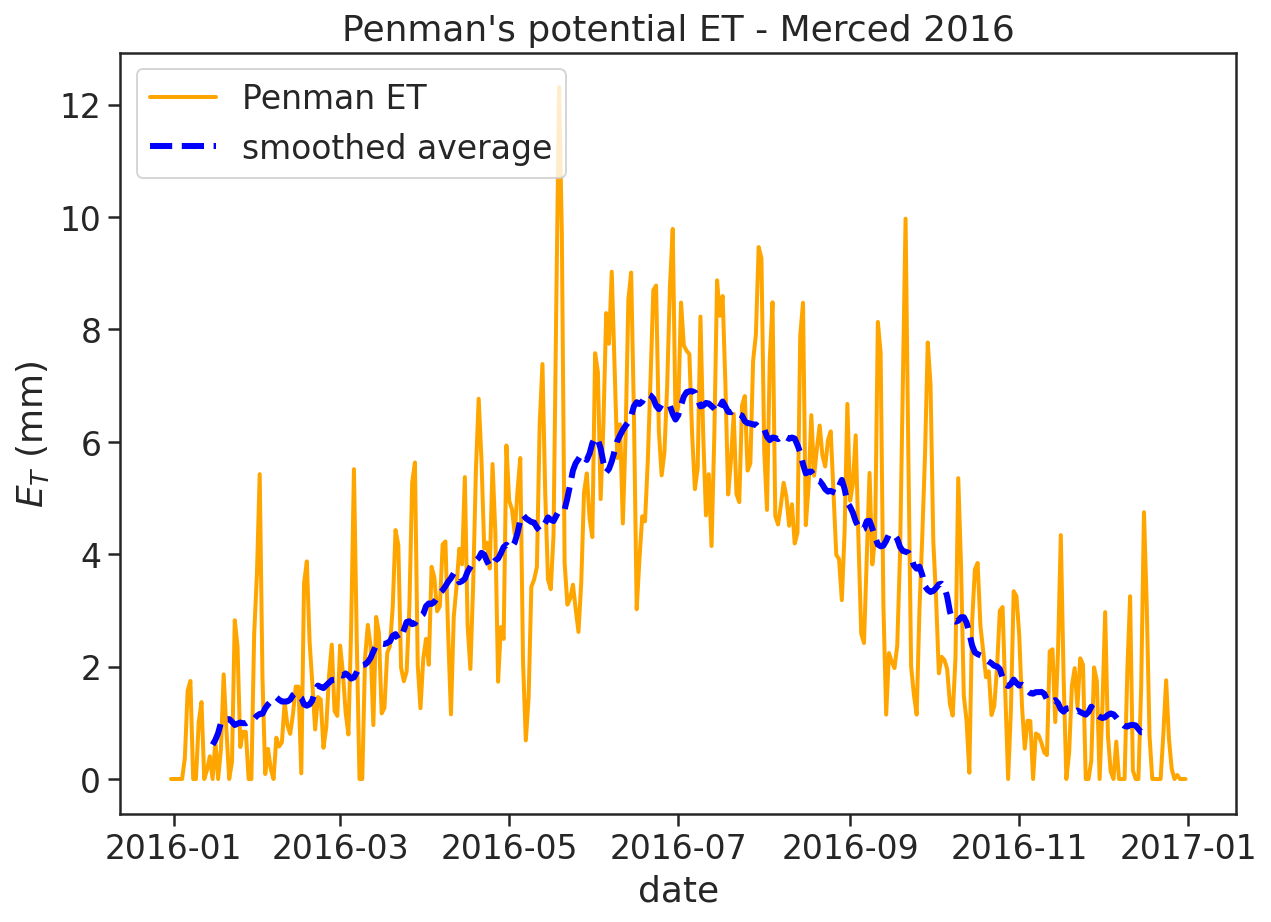

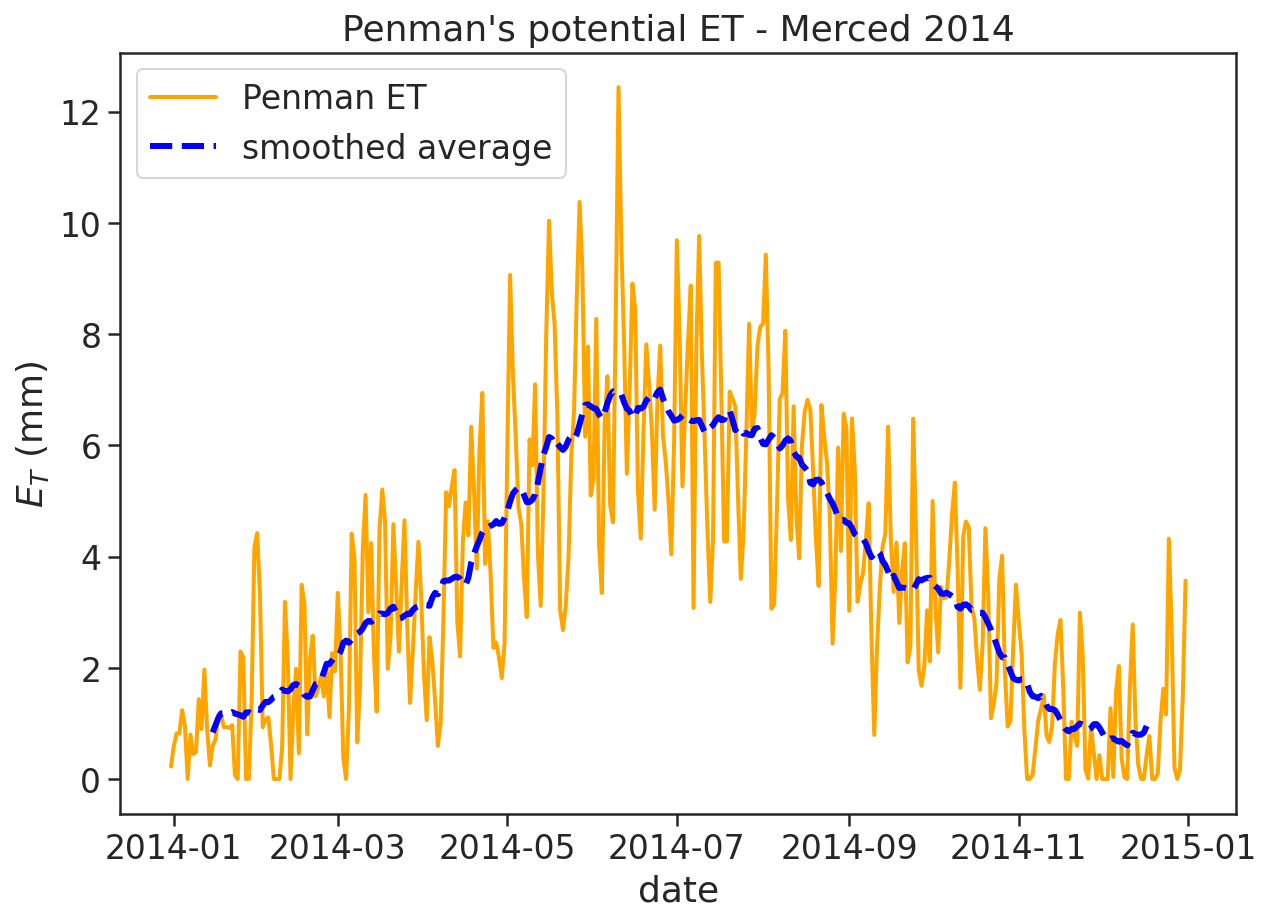

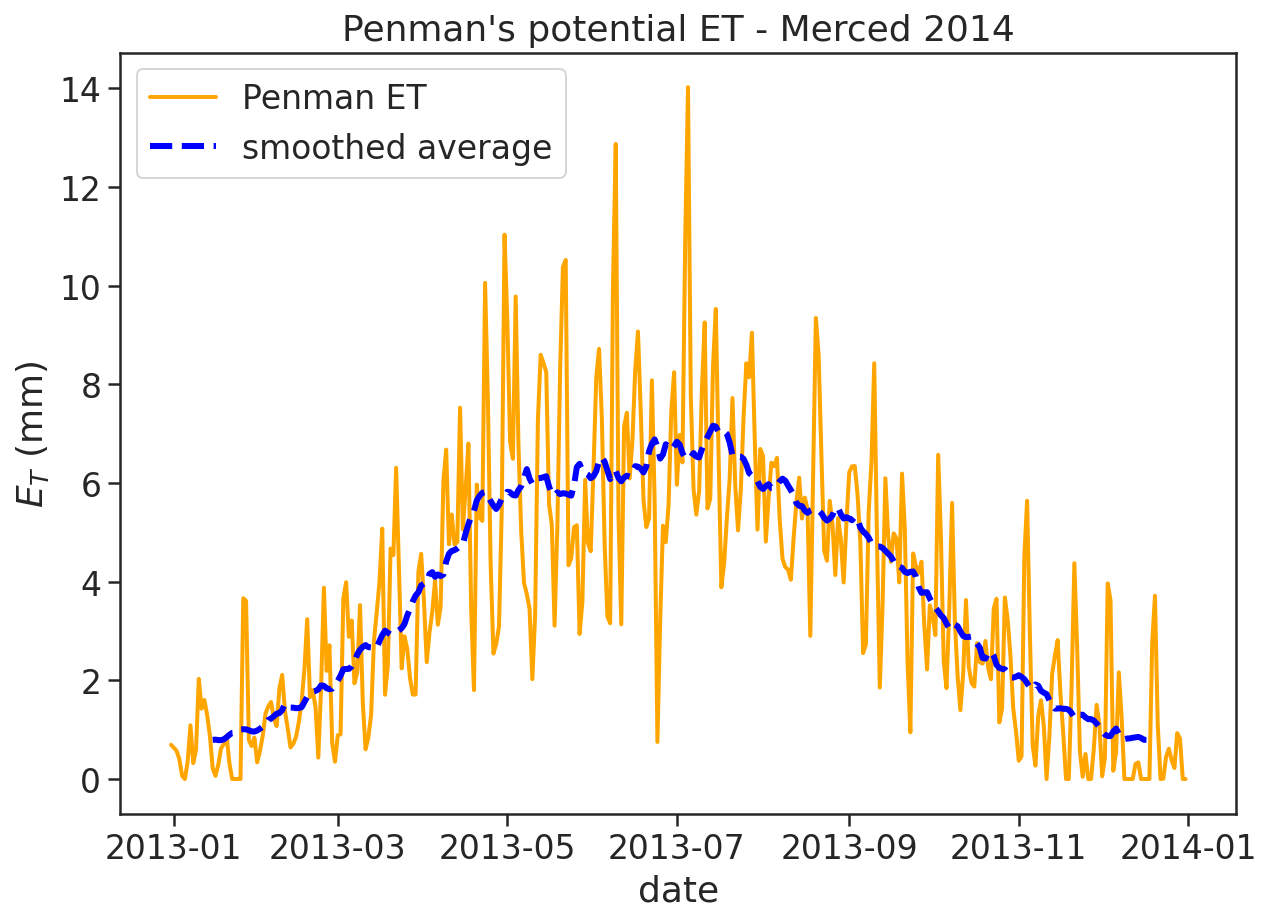

In [89]:
#graph ET penman 2016:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(df_pen['E_penman'],label= "Penman ET", color="orange",  linewidth=2)
penman_smooth = df_pen['E_penman'].rolling(30, center=True).mean()          #smooth avarege
ax.plot(penman_smooth, label='smoothed average', color="blue", linestyle="--", linewidth=3)
ax.set(xlabel="date",
       ylabel=r"$E_T$ (mm)",
       title="Penman's potential ET - Merced 2016");
ax.legend(loc = 'upper left')
plt.savefig("Penman_2016.png")

#graph ET penman 2014:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(df_pen2014['E_penman'],label= "Penman ET", color="orange",  linewidth=2)
penman_smooth = df_pen2014['E_penman'].rolling(30, center=True).mean()          #smooth avarege
ax.plot(penman_smooth, label='smoothed average', color="blue", linestyle="--", linewidth=3)
ax.set(xlabel="date",
       ylabel=r"$E_T$ (mm)",
       title="Penman's potential ET - Merced 2014");
ax.legend(loc = 'upper left')
plt.savefig("Penman_2014.png")

#graph ET penman 2013:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(df_pen2013['E_penman'],label= "Penman ET", color="orange",  linewidth=2)
penman_smooth = df_pen2013['E_penman'].rolling(30, center=True).mean()          #smooth avarege
ax.plot(penman_smooth, label='smoothed average', color="blue", linestyle="--", linewidth=3)
ax.set(xlabel="date",
       ylabel=r"$E_T$ (mm)",
       title="Penman's potential ET - Merced 2014");
ax.legend(loc = 'upper left')
plt.savefig("Penman_2013.png")

In [90]:
# some numbers to present:
# df_pen['E_penman'].mean()
# df_pen['E_penman'].max()
# df_pen['E_penman'].std()
# df_pen['E_penman'].sum()

## 3. Stream flow

In this chapter we will perform an analysis on stream flow data. We will perform statistics of trends and extreme events and finally we will compare the results to the precipitation data.

#### a. import and orgenize the data

Because it is important for us to focus on general trends, I downloaded the daily information and not the sub-hourly information in order to make the comparison to precipitation more convenient.

In [91]:
data_file = "Merced_streamFlow.txt"
df_q = pd.read_csv(data_file,
                        header=31,                      # no headers needed, we'll do that later
                        delim_whitespace=True,            # blank spaces separate between columns
                        na_values=["Bkw"]  # substitute these values for missing (NaN) values
                )
df_q
df_q.columns = ['agency_cd', 'site_no','datetime','discharge','code']                       # rename df columns with headers columns
df_q['date_and_time'] = df_q['datetime']  # combine date+time into datetime
df_q['date_and_time'] = pd.to_datetime(df_q['date_and_time'])        # interpret datetime
df_q = df_q.set_index('date_and_time')                          # make datetime the index
df_q['discharge'] = df_q['discharge'].astype(float)
df_q['discharge'] = df_q['discharge'] * 0.0283168 # convert cubic feet to m3
df_q        #uncomment to see the full DataFrame

,agency_cd,site_no,datetime,discharge,code
date_and_time,,,,,
1902-07-03,USGS,11270900,1902-07-03,25.768288,A
1902-07-04,USGS,11270900,1902-07-04,21.237600,A
1902-07-05,USGS,11270900,1902-07-05,19.028890,A
1902-07-06,USGS,11270900,1902-07-06,17.103347,A
1902-07-07,USGS,11270900,1902-07-07,15.291072,A
...,...,...,...,...,...
2020-09-26,USGS,11270900,2020-09-26,21.605718,A
2020-09-27,USGS,11270900,2020-09-27,20.756214,A
2020-09-28,USGS,11270900,2020-09-28,20.331462,A


#### b. interannual variability of discharge

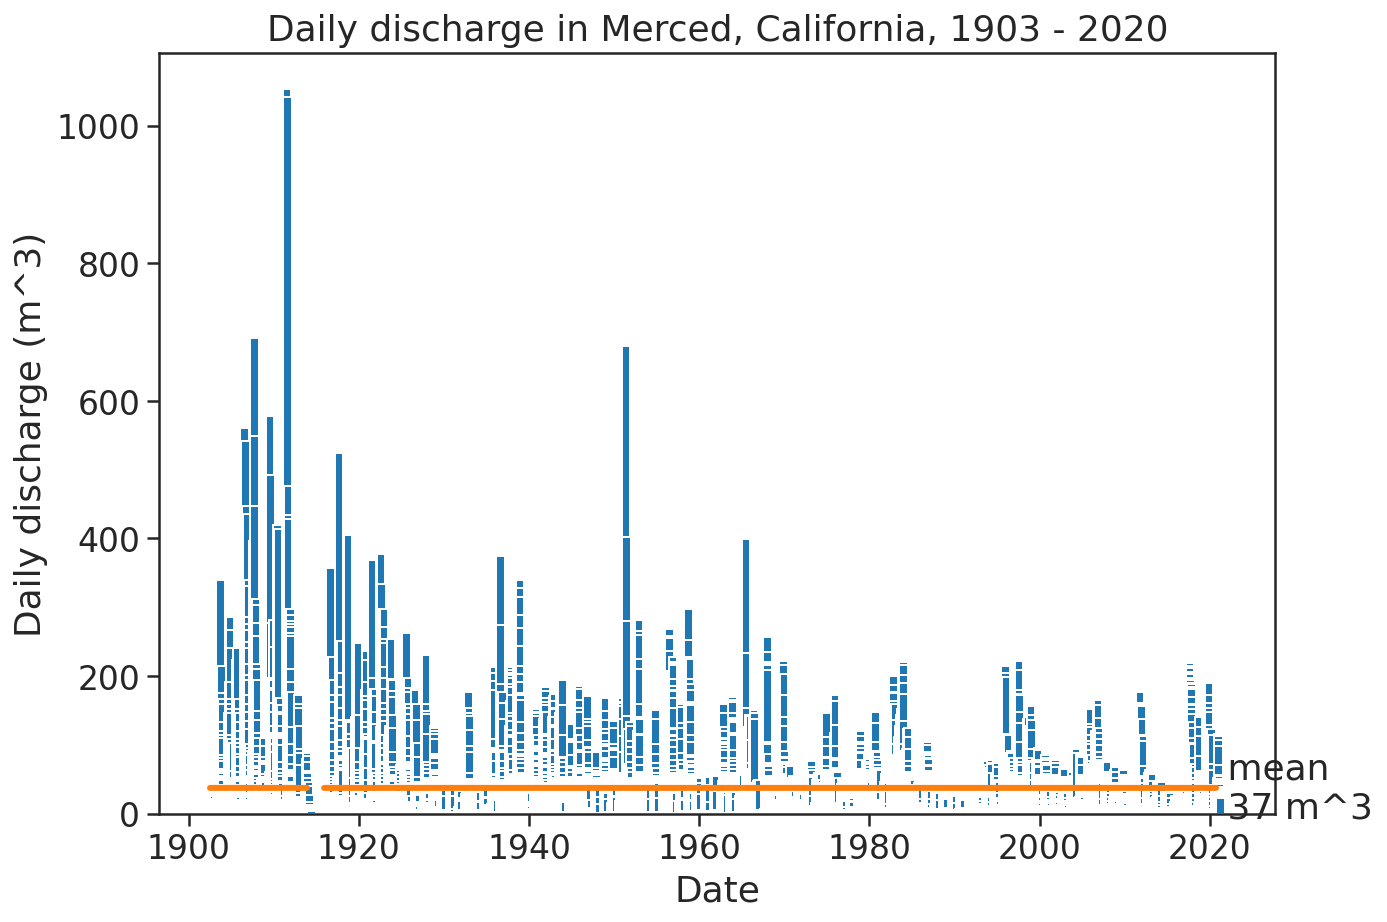

In [92]:
# initial graph:

#creating graph
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(df_q.index, df_q['discharge'],
       width=365, align='edge', color="tab:blue")
discharge_mean_merced = df_q['discharge'].mean()
ax.plot(df_q['discharge']*0 + discharge_mean_merced, linewidth=3, color="tab:orange")
ax.set(xlabel="Date",
       ylabel="Daily discharge (m^3)",
       title=f"Daily discharge in Merced, California, 1903 - 2020");
ax.text(df_q.index[-1], discharge_mean_merced, " mean\n {:.0f} m^3".format(discharge_mean_merced),
        horizontalalignment="left", verticalalignment="center")
plt.savefig("daily_discharge.PNG")

let's take a look also on the annual data using resample function:

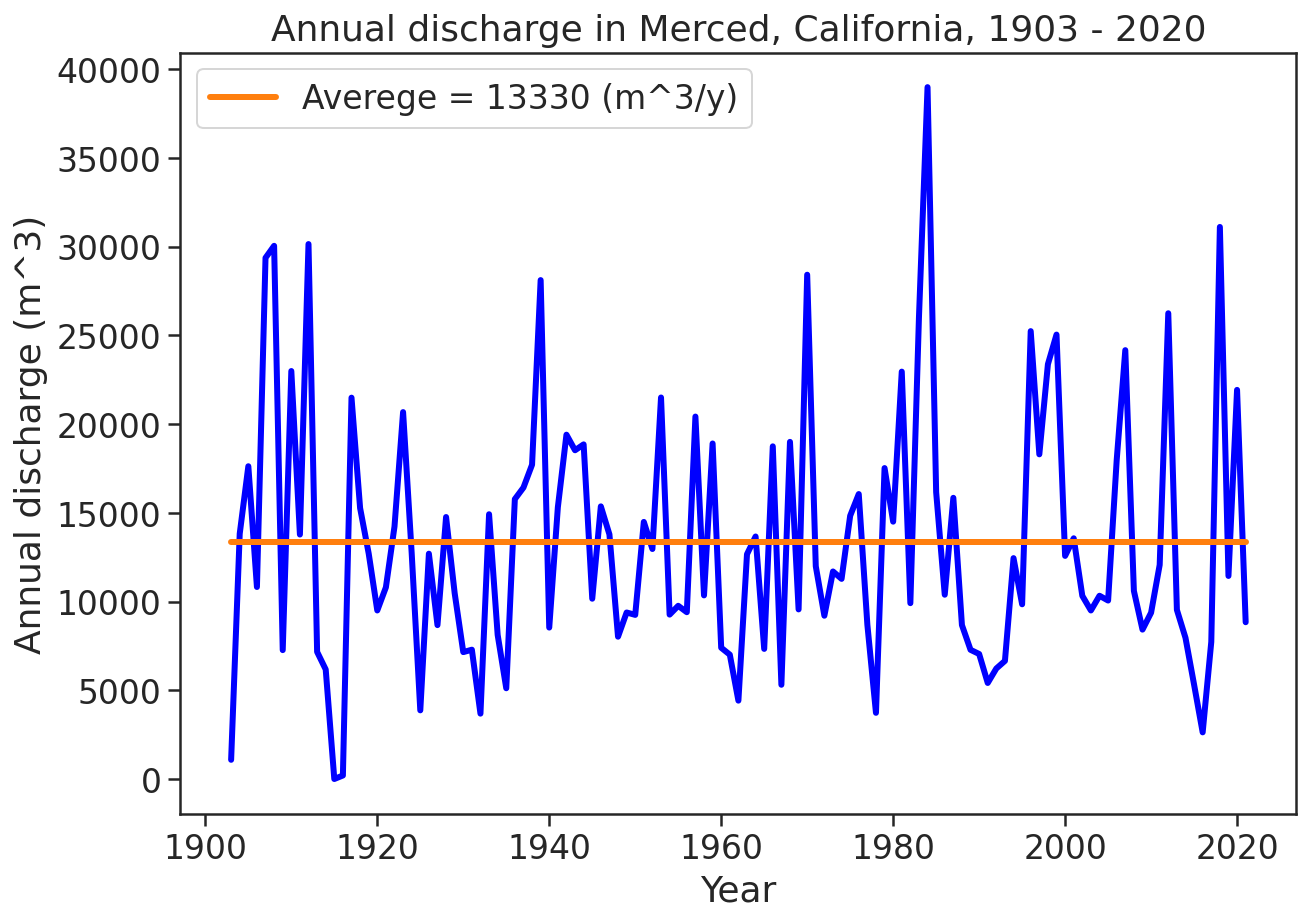

In [93]:
df_q_annual = (df_q['discharge'].resample('Y').sum().to_frame()) # resample the ET from month into year and sum for every year

# graph:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(df_q_annual, color="blue",  linewidth=3)
q_mean = df_q_annual.mean()
ax.plot(df_q_annual*0 + q_mean, linewidth=3, color="tab:orange",label="Averege = 13330 (m^3/y)") 
ax.set(xlabel="Year",
       ylabel="Annual discharge (m^3)",
       title="Annual discharge in Merced, California, 1903 - 2020");
ax.legend()
plt.savefig("annual_discharge.PNG")

We will examine the variance similar to the way we calculated it on the precipitation using **2 graphs and CV value**:

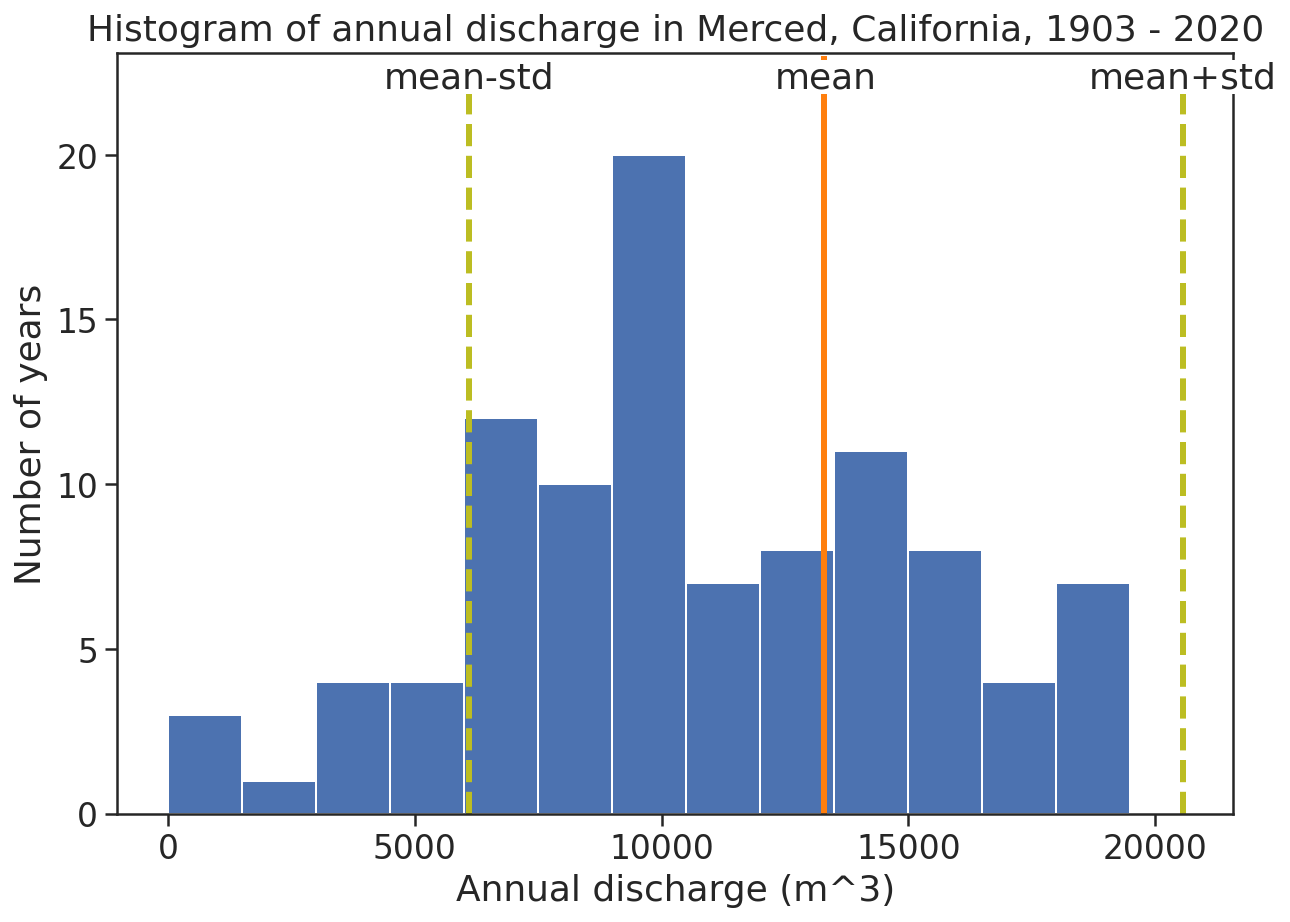

In [94]:
fig, ax = plt.subplots(figsize=(10,7))
# calculate mean and standard deviation
discharge_mean = df_q_annual.mean()
discharge_std = df_q_annual.std()
# plot histogram
b = np.arange(0, 20000, 1500)  # bins from 0 to 55, width = 5
ax.hist(df_q_annual, bins=b)
# plot vertical lines with mean, std, etc
ylim = np.array(ax.get_ylim())
ylim[1] = ylim[1]*1.1
ax.vlines(13300,0,23,linewidth=3, color="tab:orange") # create vertical line with different way
ax.plot([discharge_mean+discharge_std]*2, ylim, linewidth=3, linestyle="--", color="tab:olive")
ax.plot([discharge_mean-discharge_std]*2, ylim, linewidth=3, linestyle="--", color="tab:olive")
ax.set_ylim(ylim)
# write mean, std, etc
ax.text(discharge_mean, ylim[1]*0.99, "mean",
        horizontalalignment="center",
        verticalalignment="top",
        bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
ax.text(discharge_mean+discharge_std, ylim[1]*0.99, "mean+std",
        horizontalalignment="center",
        verticalalignment="top",
        bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
ax.text(discharge_mean-discharge_std, ylim[1]*0.99, "mean-std",
        horizontalalignment="center",
        verticalalignment="top",
        bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
# adjust labels, ticks, title, limits, etc
ax.set_title("Histogram of annual discharge in Merced, California, 1903 - 2020")
ax.set_xlabel("Annual discharge (m^3)")
ax.set_ylabel("Number of years")
# save figure
plt.savefig("discharge_histogram_merced_with_mean_and_std.png")

In [95]:
# CV calculation
CV = discharge_std / discharge_mean
print("CV(discharge Merced) = ",float(CV))

CV(discharge Merced) =  0.5419575451283931


We will examine whether there is a trend over the years:

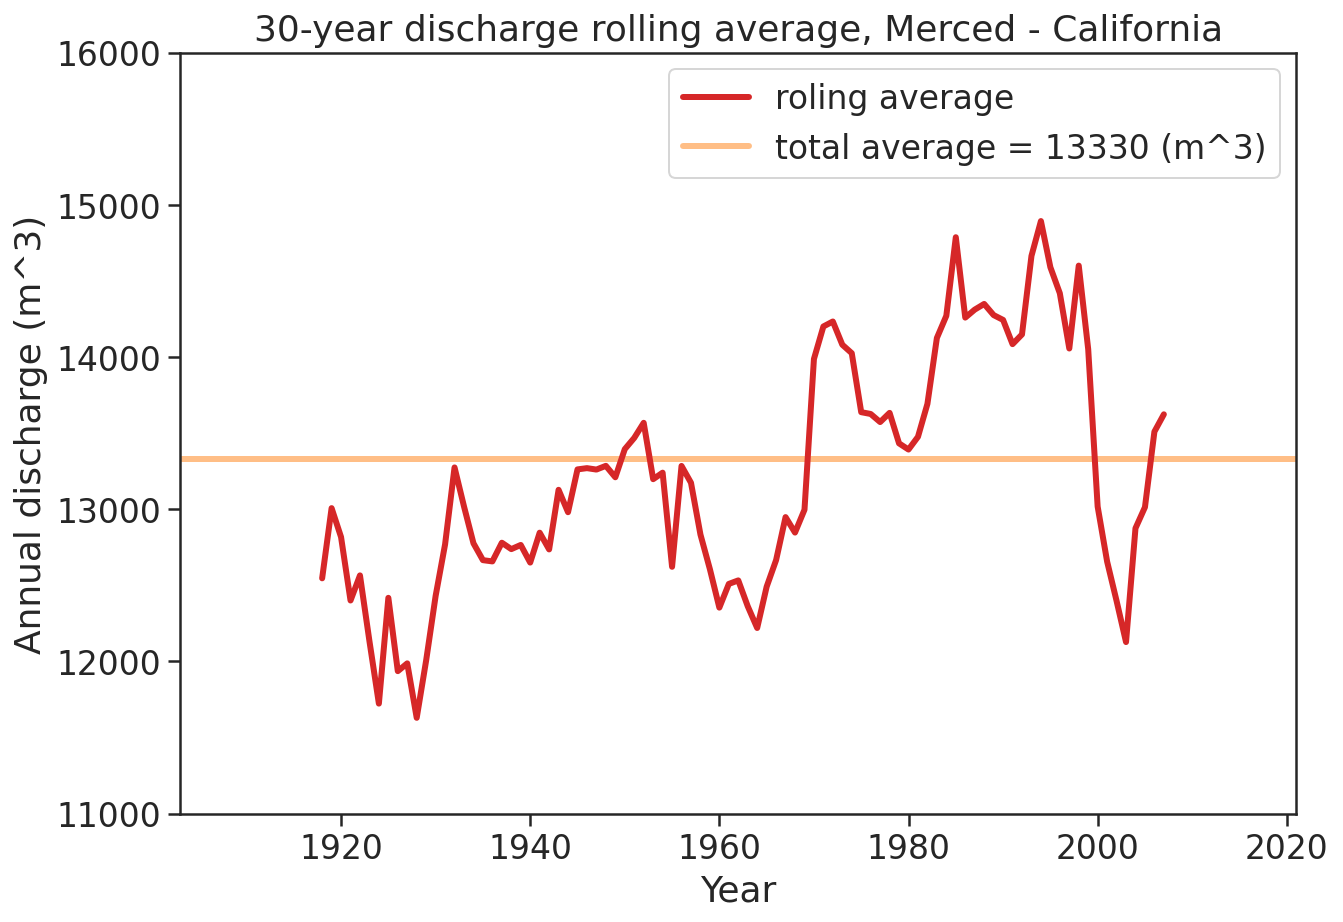

In [96]:
fig, ax = plt.subplots(figsize=(10,7))

rolling_mean = df_q_annual['discharge'].rolling(30, center=True).mean()
ax.plot(rolling_mean, linewidth=3, color="tab:red",label = "roling average", zorder=5)

ax.set_title("30-year discharge rolling average, Merced - California")
ax.set_xlabel("Year")
ax.set_ylabel("Annual discharge (m^3)")

# windows of length 30 years
windows = [[x,x+29] for x in [1903,1915,1940,1965,1980,1990]]
for window in windows:
    start_date = f"{window[0]:d}-01-01"
    end_date = f"{window[1]:d}-01-01"
    window_mean = df_q_annual['discharge'][start_date:end_date].mean()
ax.set_ylim([11000, 16000])

# plot mean
ax.plot(df_q_annual*0 + discharge_mean, linewidth=3, color="tab:orange", alpha=0.5,label = "total average = 13330 (m^3)")
ax.set_xlim([df_q_annual['discharge'].index[0], df_q_annual['discharge'].index[-1]])
ax.legend()
# save figure
plt.savefig("rolling_discharge_average_Merced.png")

#### d. extreme discharge events and return periods

The calculations in this section will be done in the same way as were done in the precipitation analysis, so we will explain in the comments only what requires an explanation, but beyond that you can read Part A to understand the calculations in more depth.

##### pdf & cdf
Now lets make two graphs:

a) the histogram for the annual maximum (pdf)

b) the cumulative probability (cdf).

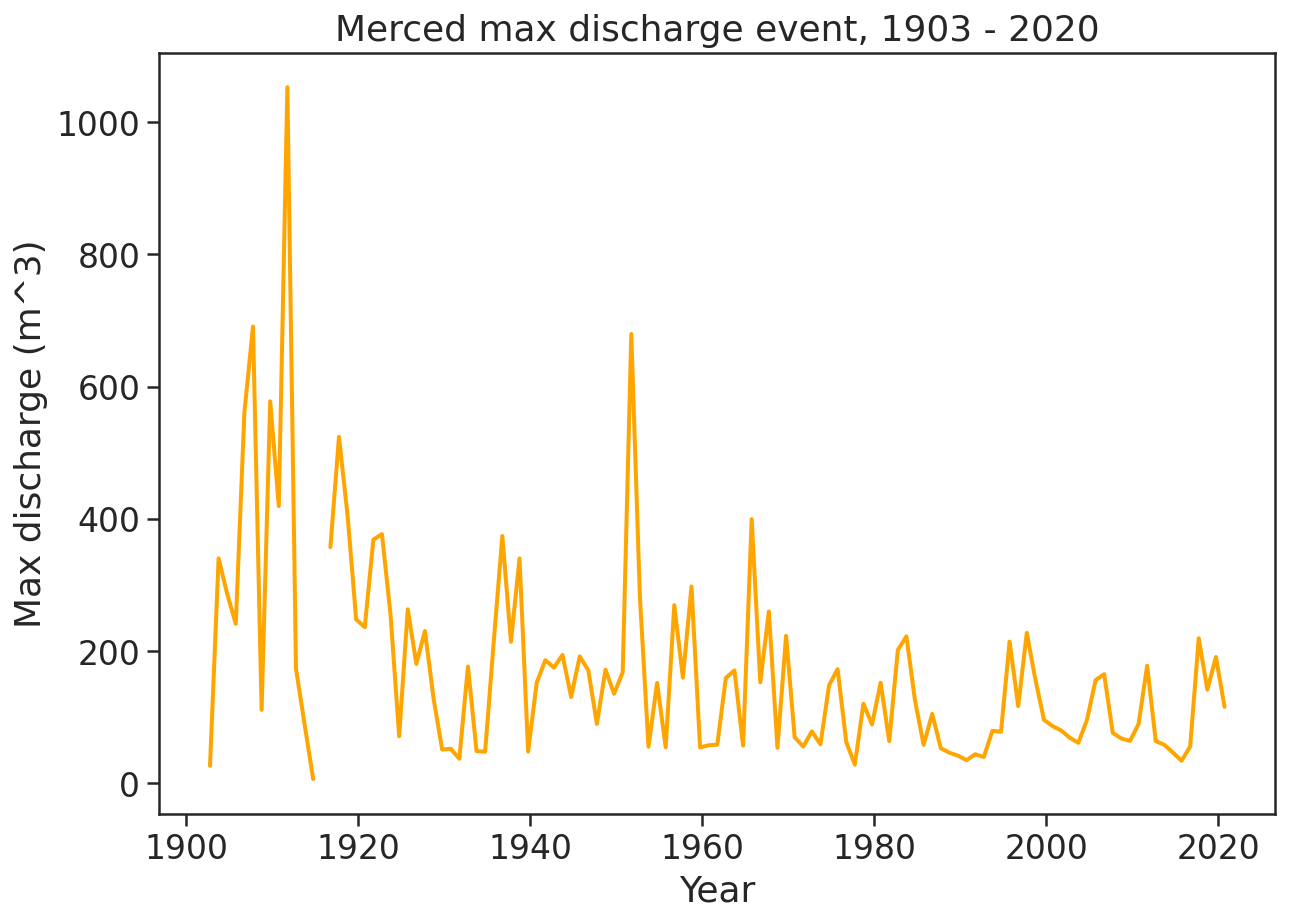

In [97]:
#resample the data and find the maximum for all year:
max_annual = (df_q['discharge'].resample('A-SEP')
                        .max()
                        .to_frame()
             )

# graph:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(max_annual, color="orange",  linewidth=2)
ax.set(xlabel="Year",
       ylabel="Max discharge (m^3)",
       title="Merced max discharge event, 1903 - 2020");

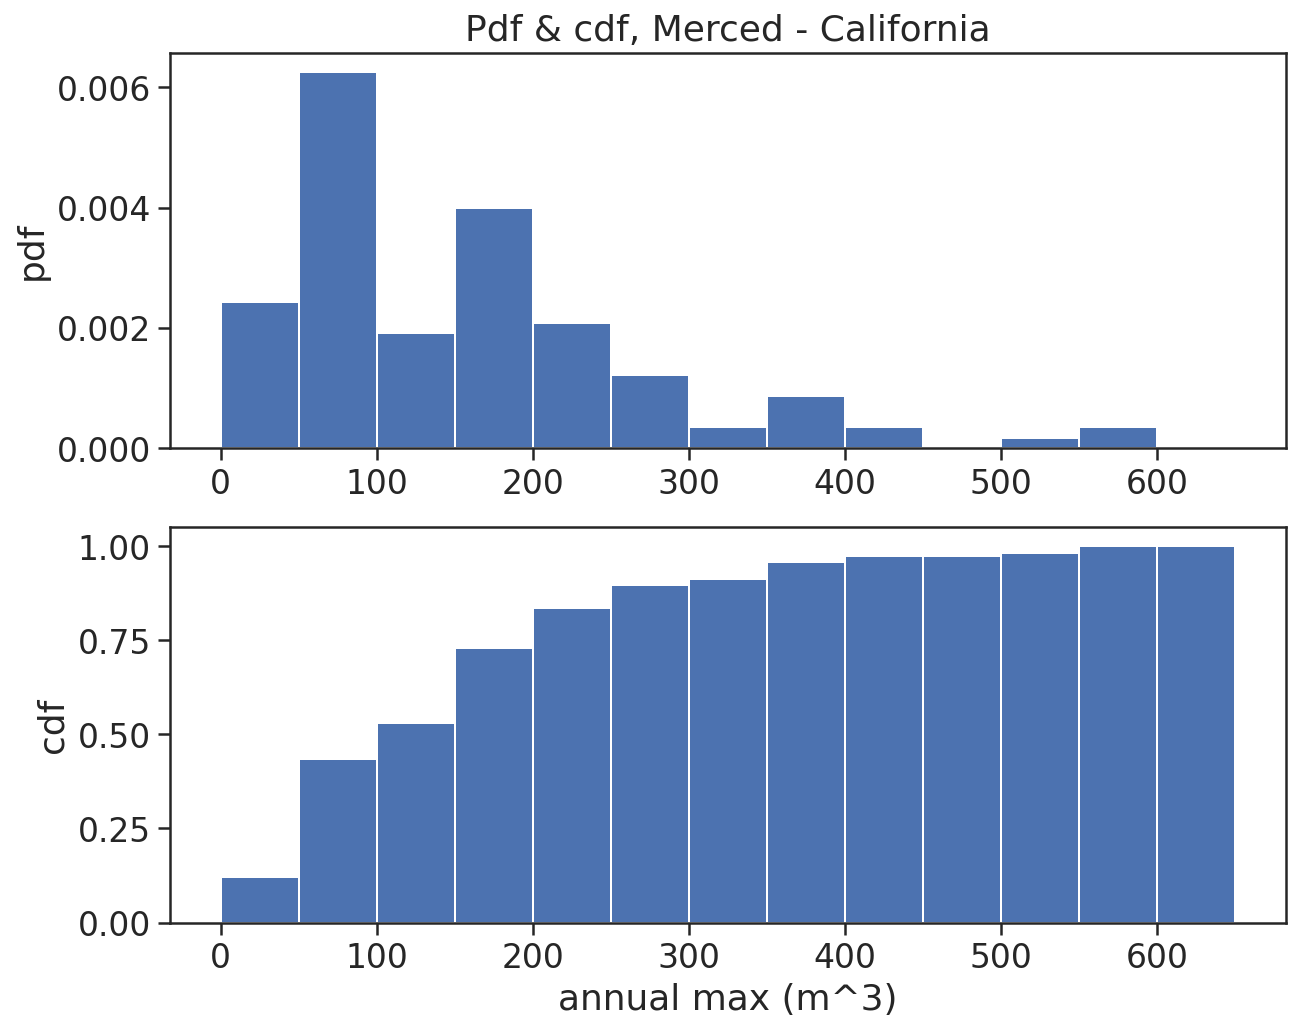

In [98]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
#taking the max values of discharge:
h=max_annual['discharge'].values
#creating histograma, defining "density = true" to get the probability instead of quntity
ax1.hist(h, bins=np.arange(0,700,50), density=True)
# ax1.set_ylim([0,1])
#creating cdf - defining "cumulative =1" to accept the probability that we will not exceed the current range
ax2.hist(h, bins=np.arange(0,700,50), density=True, cumulative=1)
ax1.set_title("Pdf & cdf, Merced - California")
ax1.set(ylabel="pdf")
ax2.set(xlabel="annual max (m^3)",
        ylabel="cdf",        )
plt.savefig("discharge_pdf_cdf.png")

##### Weibull plotting position & Return period:

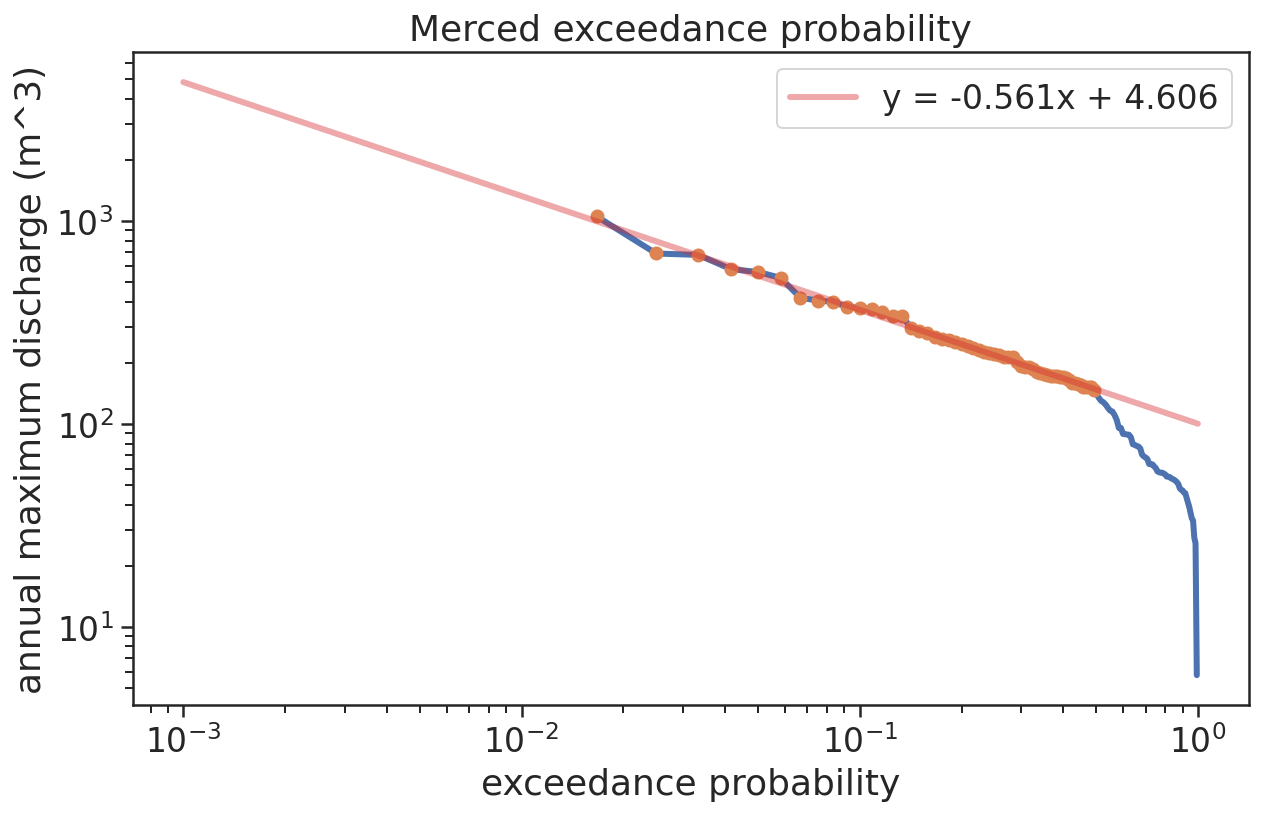

In [99]:
#sorting the values of discharge column from the low to high (ascending=True)
max_annual = max_annual.sort_values(by=['discharge'], ascending=True)
#fefining n,m,Pm, Tr and adding colunms to max_anual:
n = len (max_annual)
max_annual['m'] = np.arange(1,n+1)
max_annual['Pm'] = max_annual['m']/(n+1)
#we want the exceedance probability so we need to write it like this:
max_annual['Tr'] = 1/(1-max_annual['Pm'])
m = max_annual['m']
Pm = m / (n+1)
Tr = 1 / (1 - Pm)
#max_annual
fig, ax = plt.subplots(figsize=(10, 6))

depth = max_annual['discharge'].values
exc_prob = (1-Pm).values

ax.plot(exc_prob, depth, lw=3)
#only the leaner part (after some iterations, without the non-leaner data at the beginning and at the end):
exclude = 60
depth_tofit = depth[exclude:-1]
exc_prob_tofit = exc_prob[exclude:-1]
ax.plot(exc_prob_tofit, depth_tofit, 'o')

#labels and logaritmic scale:
ax.set_title("Merced exceedance probability")
ax.set(ylabel="annual maximum discharge (m^3)",
       xlabel="exceedance probability",
       xscale="log",
       yscale="log",
      )
#Now lets make leaner fit using (slope, intercept):
exc_prob_tofit_log = np.log(exc_prob_tofit) #log for the (1-Pm) values
depth_tofit_log = np.log(depth_tofit) #log for the discharge values
slope, intercept = np.polyfit(exc_prob_tofit_log, depth_tofit_log, 1) #we are writing "1" cecause we want leaner equation

def equation(p):
    return np.exp(slope*np.log(p) + intercept) #A function that returns y=exp(log(x)+intercept)
prob = [1e-3,1-1e-3]
ax.plot(prob, equation(prob), lw=3, color="tab:red", alpha=0.4,label = "y = -0.561x + 4.606")
ax.legend()

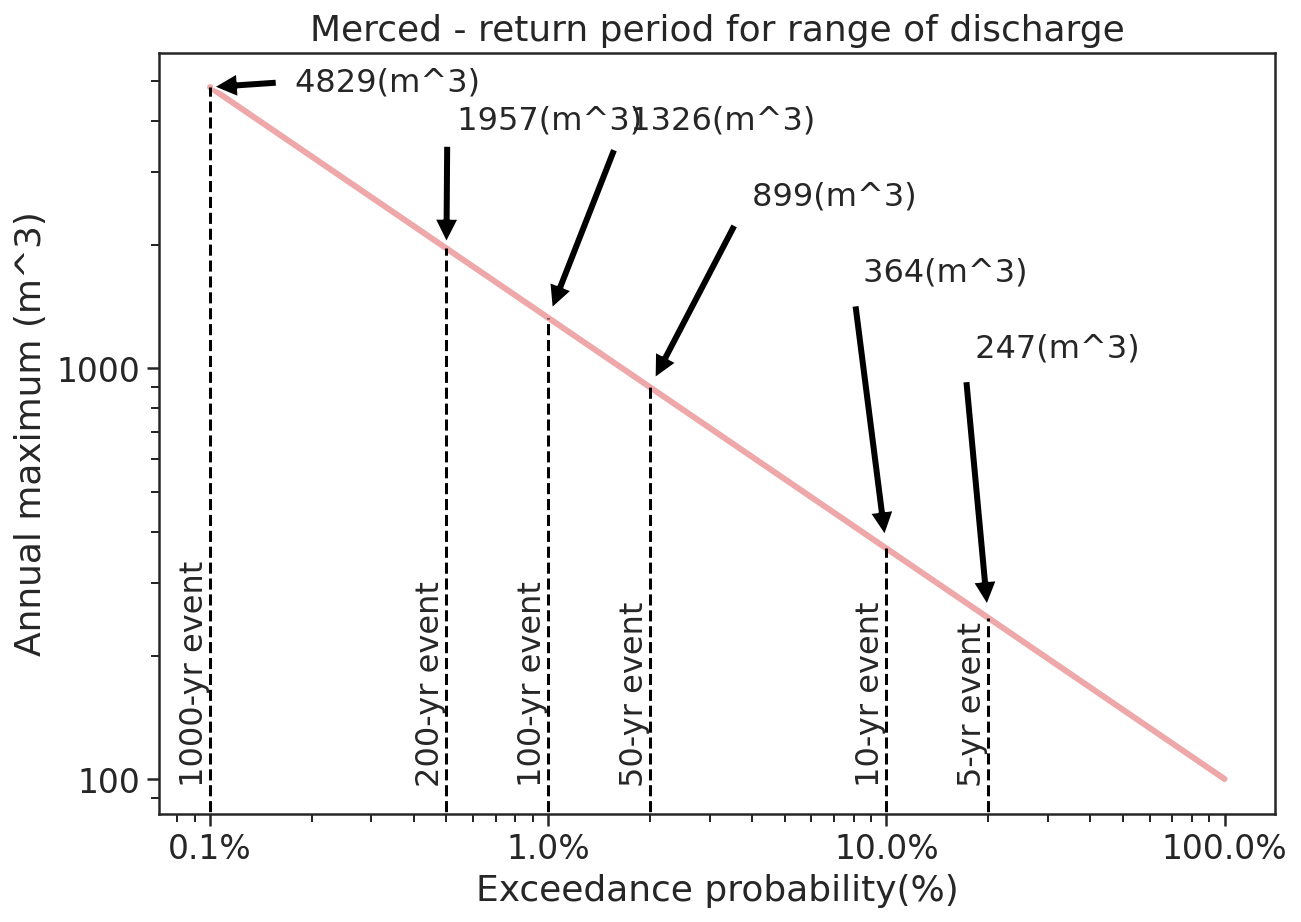

In [100]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(10,7))
prob = [1e-3,1-1e-3]

def equation(p):
    return np.exp(slope*np.log(p) + intercept)

ax.plot(prob, equation(prob), lw=3, color="tab:red", alpha=0.4)
one_in_x_years = np.array([5, 10, 50, 100, 200, 1000])

for y in one_in_x_years:
    ax.plot([1/y]*2, [0, equation(1/y)], color="black", ls="--")
    ax.text(1/y, 100, f"{y}-yr event", rotation=90, ha="right", fontsize=16)
ax.set(ylabel="Annual maximum (m^3)",
       xlabel="Exceedance probability(%)")
ax.set_title("Merced - return period for range of discharge")
ax.set_xticks([0.1, 0.2,0.5, 1.0])
ax.set_yticks([200, 400, 800, 1000, 2000, 1000])
ax.set_xscale("log")
ax.set_yscale("log")
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.1f}%'.format(y*100)))
ax.annotate(f" {equation(1/5):.0f}(m^3)",
            xy=(1/5, equation(1/5)), xycoords='data',
             xytext=(0.8, 0.6), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f" {equation(1/10):.0f}(m^3)",
            xy=(1/10, equation(1/10)), xycoords='data',
             xytext=(0.7, 0.7), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f" {equation(1/50):.0f}(m^3)",
            xy=(1/50, equation(1/50)), xycoords='data',
             xytext=(0.6, 0.8), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f" {equation(1/100):.0f}(m^3)",
            xy=(1/100, equation(1/100)), xycoords='data',
             xytext=(0.5, 0.9), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f" {equation(1/200):.0f}(m^3) ",
            xy=(1/200, equation(1/200)), xycoords='data',
             xytext=(0.35, 0.9), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f" {equation(1/1000):.0f}(m^3)",
            xy=(1/1000, equation(1/1000)), xycoords='data',
             xytext=(0.2, 0.95), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.savefig("return_period_discharge.png")

##### e. discarge and precipitation

lets compare the dischrge and the rain over the years:

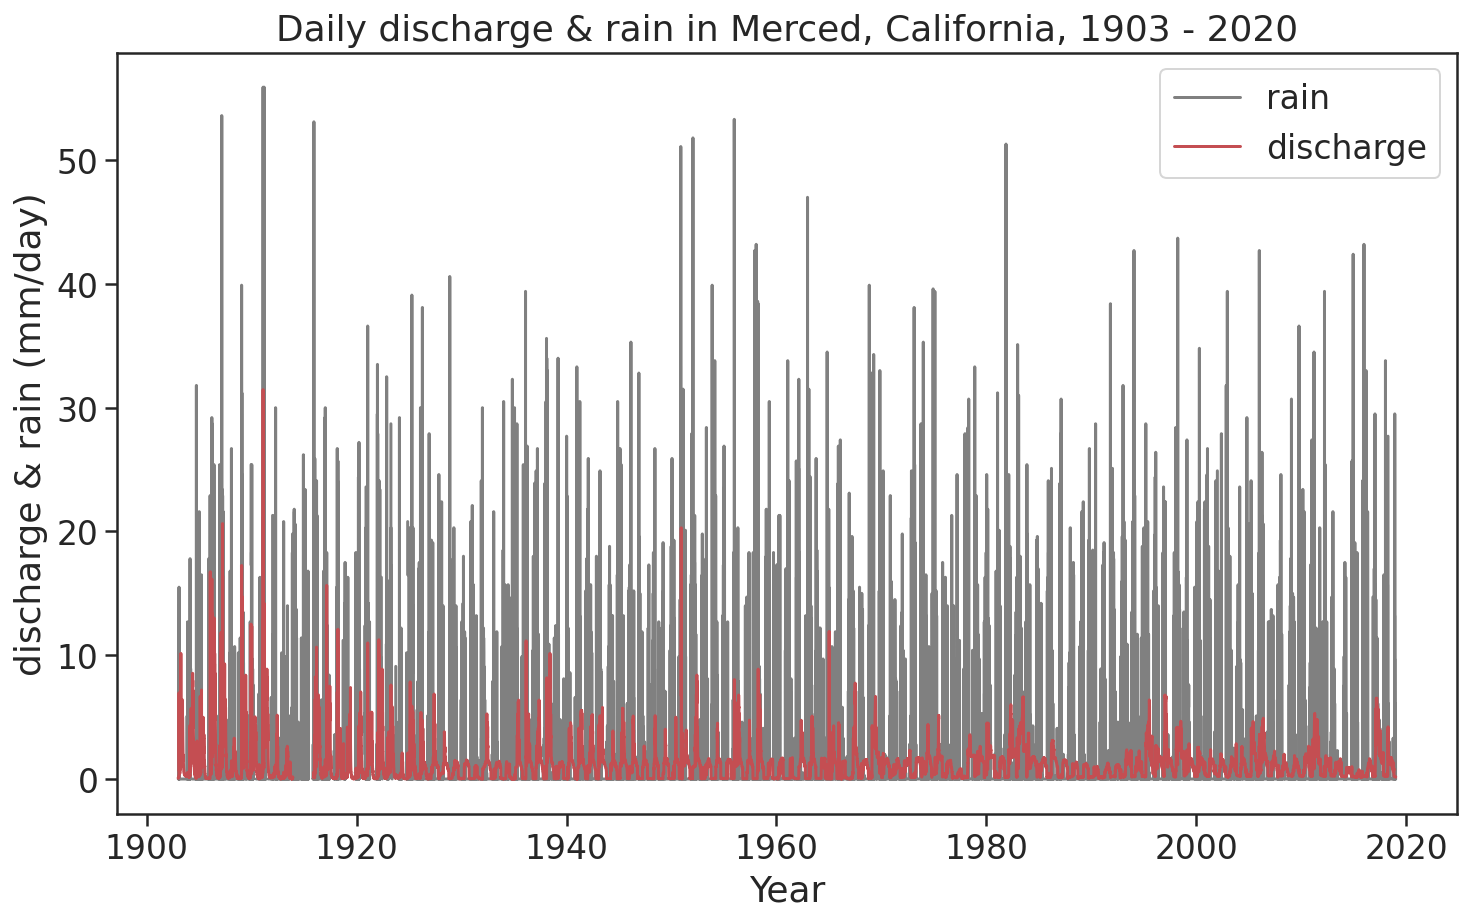

<Figure size 864x504 with 0 Axes>

In [101]:
area = 1117 * 1.609344E3**2 # convert squared miles to squared meters
df_q['discharge_rain'] = df_q['discharge'] * (60 * 60 * 24) *1000 / area  # m^3/s to mm/day

# graph:
# fig, ax = plt.subplots(1, figsize=(10,7))
# ax.plot(df_q['discharge_rain'].loc["1903-01-01":"2019-01-01"],color="tab:orange",linewidth=4,label="discharge (mm)")
# # ax.plot(df.loc["1903-01-01":"2019-01-01"]['PRCP'], color="grey",linewidth=4, label="rain (mm)")
# ax.set(xlabel="Year",
#        ylabel="discharge & rain (mm/day)",
#        title="Daily discharge & rain in Merced, California, 1903 - 2020");
# ax.legend()
# plt.savefig("discharge&rain.PNG")

# X = df_q.index
  
# Assign variables to the y axis part of the curve
y = df_q['discharge_rain'].loc["1903-01-01":"2019-01-01"]
z = df.loc["1903-01-01":"2019-01-01"]['PRCP']
smooth = df.rolling(365, center=True).mean()          #smooth avarege

# Plotting both the curves simultaneously
plt.plot( z, color='grey', label='rain')
plt.plot( y, color='r', label='discharge')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Year")
plt.ylabel("discharge & rain (mm/day)")
plt.title("Daily discharge & rain in Merced, California, 1903 - 2020")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

plt.savefig("discharge_rain.png")

## 4. Budyko's framework

To calculate where the location you chose falls on the (PET/P,ET/P) space for at least three different years of interest.

In [102]:
# df with all the data of the p/ q in the years 2013,2014,2016
yearsq =df_q["2013-01-01":"2013-12-30"]['discharge']
yearsq = yearsq.append(df_q["2014-01-01":"2014-12-30"]['discharge'])
yearsq = yearsq.append(df_q["2016-01-01":"2016-12-30"]['discharge'])

yearsp = df["2013-01-01":"2013-12-30"]['PRCP']
yearsp = yearsp.append(df["2014-01-01":"2014-12-30"]['PRCP'])
yearsp = yearsp.append(df["2016-01-01":"2016-12-30"]['PRCP'])

In [103]:
## create budyko data frame from the years we calculated Penman PET for
penmans = pd.concat((df_pen2013['E_penman'],df_pen2014['E_penman'],df_pen['E_penman']),
                    axis=0)                    # join all data to single column, year under year
budyko  = pd.concat((yearsq,yearsp,penmans),
                    axis=1)                    # join columns next to each other according to index (same day)
budyko.columns = ['Q','P','PET']               # rename according to budyko equations
budyko = budyko.resample('Y').mean().dropna()  # calculate year mean and drop years without penman
# P, PET are in the desired units of [L T^-1] mm/day. let us convert the Q to the same units
# Drainage area: 1117 square miles
area = 1117 * 1.609344E3**2                                # squared miles to squared meters
budyko['Q']  = budyko['Q'] * (60 * 60 * 24) * 1000 / area  # m^3/s to mm/day
budyko['ET'] = budyko['P']-budyko['Q']                    # P = ET + Q according to budyko's framework
budyko['ET'][budyko['ET']<0] = 0 # all the nagetive values into 0
budyko['PET'] = penmans.resample('Y').mean().dropna()
budyko

,Q,P,ET,PET
2013-12-31,0.652179,0.332394,0.000000,3.691570
2014-12-31,0.435886,0.739755,0.303869,3.559734
2016-12-31,0.631639,1.220747,0.589108,3.377142


(11.105994810455103, 0.0)
(4.812042190013537, 0.4107697552904408)
(2.7664554385683524, 0.4825802408397488)


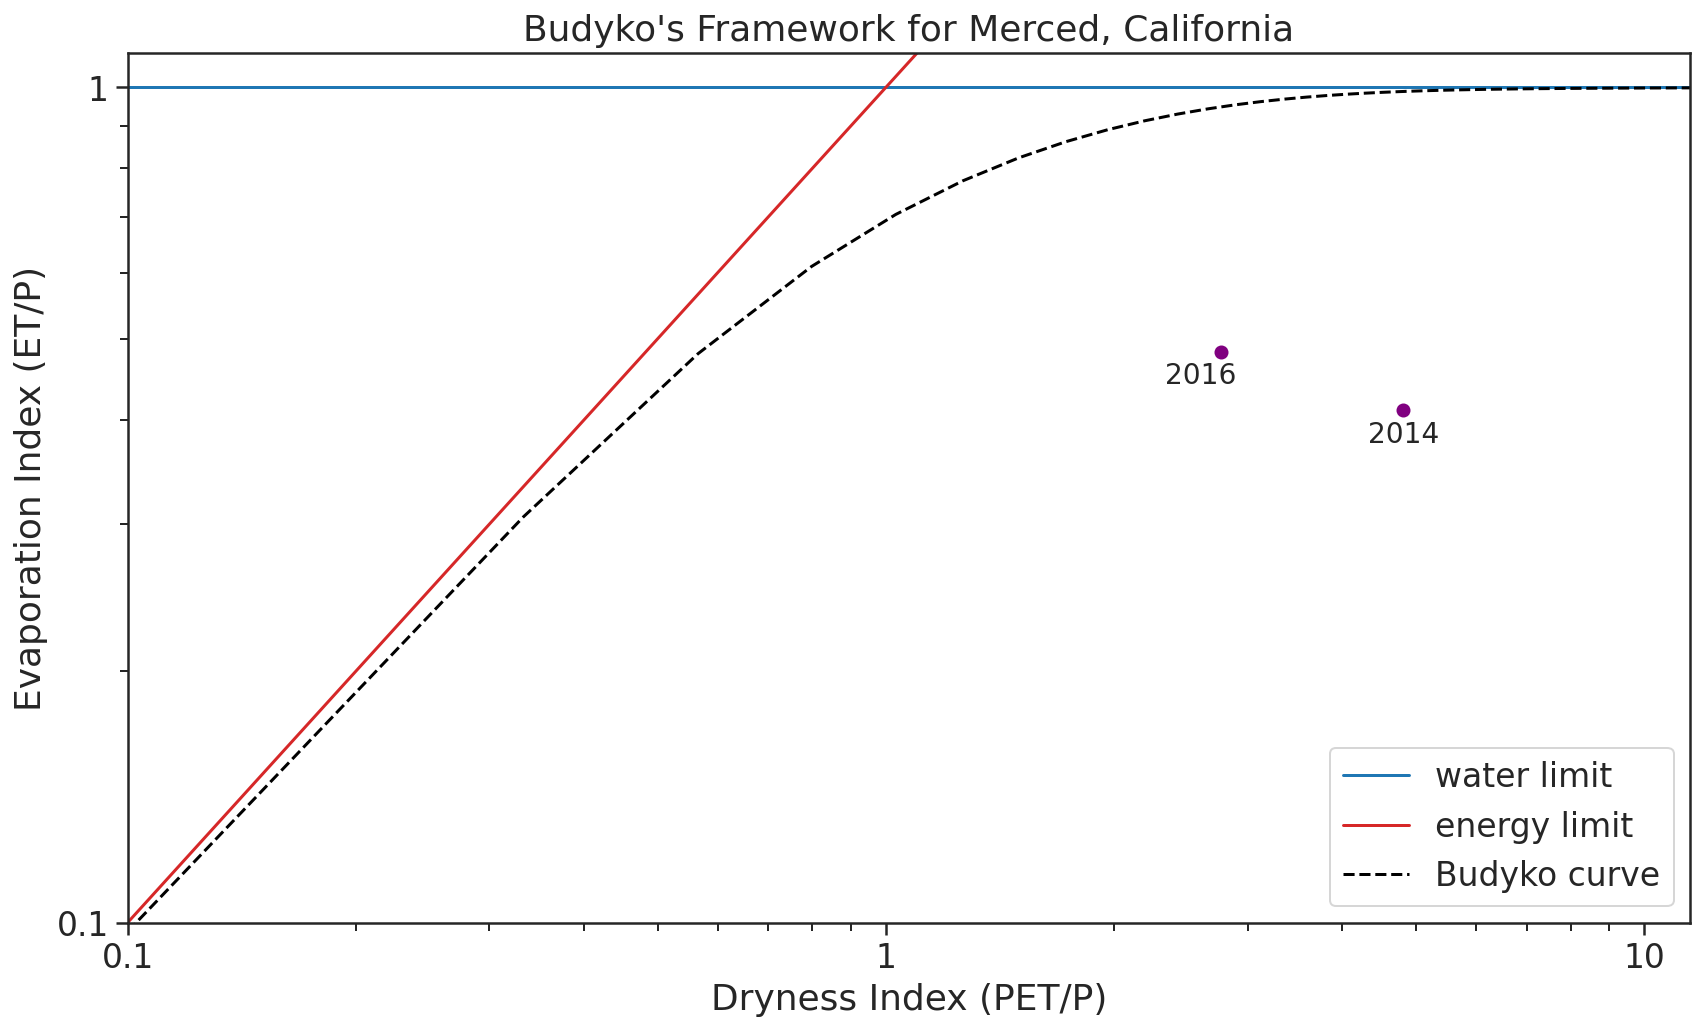

In [104]:
years = ['2013-12-31','2014-12-31','2016-12-31']
# plot budyko's results for 3 selected years
fig, ax = plt.subplots(figsize=(14,8)) 
offsets = (10,0,-10)
for year,offset in zip(years,offsets):
    d = budyko.loc[year]
    point = (d['PET']/d['P'],d['ET']/d['P'])
    print(point)
    ax.scatter(*point, color='purple')
    ax.annotate(year[:4], xy=point, xycoords='data',
                xytext=(offset,-12), textcoords='offset points',
                fontsize=14, ha="center", va='center')
ax.set_xscale("log")
ax.set_yscale("log")
ax.yaxis.set_major_formatter("{x:g}")
ax.xaxis.set_major_formatter("{x:g}")
ax.set(title=f"Budyko's Framework for Merced, California",
       xlim=[0.1,11.5], ylim=[0.1,1.1],
       ylabel="Evaporation Index (ET/P)", xlabel="Dryness Index (PET/P)")
# draw water limit
ax.axhline(1, color='tab:blue', label='water limit')
# draw energy limit
x = np.linspace(0.1,ax.get_xlim()[1])
ax.plot(x,x, color='tab:red', label='energy limit')
# draw budyko's curve
ax.plot(x,(x*np.tanh(1/x)*(1-np.exp(-x)))**0.5, color='black', ls='--', label='Budyko curve')
ax.legend()
plt.savefig("budyko.png")